# Data Exploration

## Import

In [1]:
import funcs

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_master = pd.read_csv("archive/Base.csv")
df_master.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


## Explore features

In [3]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [4]:
print("Num instances fraud", n_fraud := len(df_master[df_master["fraud_bool"]==1]), f", {n_fraud/10000}%")
print("Num instances not fraud", n_not_fraud := len(df_master[df_master["fraud_bool"]==0]), f", {n_not_fraud/10000}%")

Num instances fraud 11029 , 1.1029%
Num instances not fraud 988971 , 98.8971%


In [5]:
cats = list()
print("CATEGORICAL COLUMS (NOT BOOLEANS)")
print("_________________________________")
for col in df_master:
    if (df_master[col].dtype==np.dtype(np.object_)):
        print(col, ",", df_master[col].unique())
        cats.append(col)

CATEGORICAL COLUMS (NOT BOOLEANS)
_________________________________
payment_type , ['AA' 'AB' 'AC' 'AD' 'AE']
employment_status , ['CA' 'CB' 'CC' 'CD' 'CE' 'CF' 'CG']
housing_status , ['BA' 'BB' 'BC' 'BD' 'BE' 'BF' 'BG']
source , ['INTERNET' 'TELEAPP']
device_os , ['windows' 'other' 'linux' 'macintosh' 'x11']


In [6]:
bools = list()
counts = list()
no_info = list()
for col in df_master:
    if (df_master[col].dtype==np.dtype(np.int64)):
        if (l := len(df_master[col].unique())) == 2:
            bools.append(col)
        elif l > 2:
            counts.append(col)
        else:
            no_info.append(col) #less than 2 unique values, useless
print("BOOLEANS, 0s, 1s")
print("________________")
for b in bools:
    print(f"{b}, {len(df_master[df_master[b]==0])}, {len(df_master[df_master[b]==1])}")
print("\n")
print("COUNTERS, Min, Avg, Max")
print("_______________________")
for c in counts:
    print(f"{c}, {min(df_master[c])}, {np.mean(df_master[c])}, {max(df_master[c])}")

print("\n")
print("NO INFO, Single Value")
print("________")
for b in no_info:
    print(b, df_master[b].unique())

BOOLEANS, 0s, 1s
________________
fraud_bool, 988971, 11029
email_is_free, 470114, 529886
phone_home_valid, 582923, 417077
phone_mobile_valid, 110324, 889676
has_other_cards, 777012, 222988
foreign_request, 974758, 25242
keep_alive_session, 423053, 576947


COUNTERS, Min, Avg, Max
_______________________
prev_address_months_count, -1, 16.718568, 383
current_address_months_count, -1, 86.587867, 428
customer_age, 10, 33.68908, 90
zip_count_4w, 1, 1572.692049, 6700
bank_branch_count_8w, 0, 184.361849, 2385
date_of_birth_distinct_emails_4w, 0, 9.503544, 39
credit_risk_score, -170, 130.989595, 389
bank_months_count, -1, 10.839303, 32
device_distinct_emails_8w, -1, 1.018312, 2
month, 0, 3.288674, 7


NO INFO, Single Value
________
device_fraud_count [0]


In [7]:
print("CONTINUOUS VALUES")
print("_________________")
nums = list()
for col in df_master:
    if (df_master[col].dtype==np.dtype(np.float64)):
        print(f"{col}, {min(df_master[col])}, {np.mean(df_master[col])}, {max(df_master[col])}")
        nums.append(col)

CONTINUOUS VALUES
_________________
income, 0.1, 0.5626956000000002, 0.9
name_email_similarity, 1.4345504845275636e-06, 0.4936940949631277, 0.9999993177937188
days_since_request, 4.036859788721786e-09, 1.025705230995808, 78.45690383509861
intended_balcon_amount, -15.530554840076814, 8.661498537172486, 112.9569276953714
velocity_6h, -170.60307235124628, 5665.296604795269, 16715.565404174275
velocity_24h, 1300.3073144849477, 4769.781964962282, 9506.896596111665
velocity_4w, 2825.748405284728, 4856.324015811874, 6994.764200834217
proposed_credit_limit, 190.0, 515.85101, 2100.0
session_length_in_minutes, -1.0, 7.544940201289998, 85.89914319274027


## Visualize

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

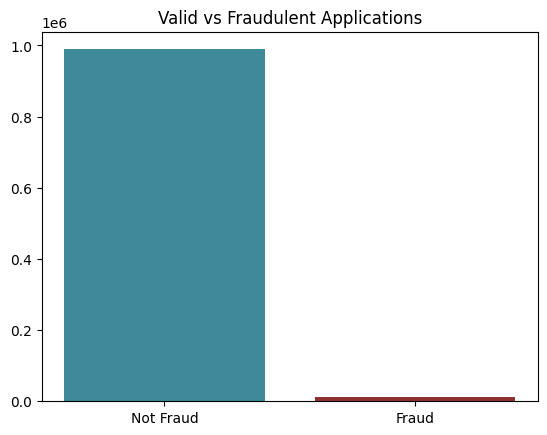

In [9]:
blue = (63/255, 137/255, 155/255, 255/255)
red = (140/255 ,49/255, 48/255 , 255/255)
plt.bar(["Not Fraud", "Fraud"], [n_not_fraud, n_fraud], color = [blue, red])
plt.title("Valid vs Fraudulent Applications")
plt.show()

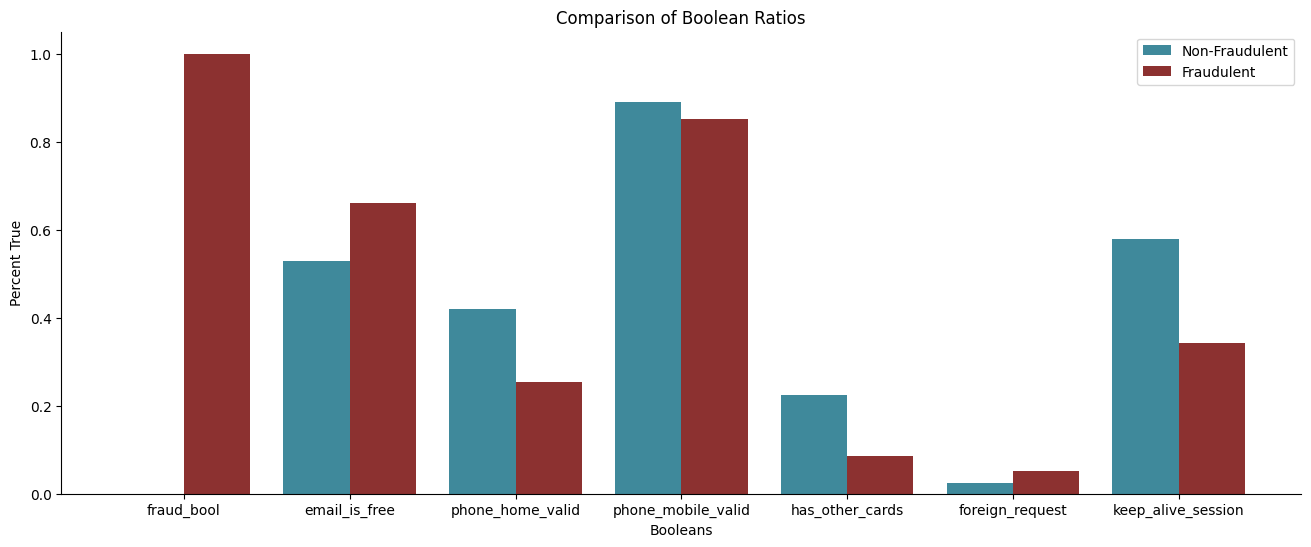

In [10]:
nf_ratios = list()
f_ratios = list()

for bool in bools:
    non_fraud_counts = df_master[df_master["fraud_bool"]==0][bool].value_counts()
    fraud_counts = df_master[df_master["fraud_bool"]==1][bool].value_counts()
    #print(non_fraud_counts)
    #print(fraud_counts)
    nf_ratio = (sum(non_fraud_counts) - non_fraud_counts[0]) / sum(non_fraud_counts)
    f_ratio = (fraud_counts[1]) / sum(fraud_counts)
    
    nf_ratios.append(nf_ratio)
    f_ratios.append(f_ratio)

X_axis = np.arange(len(bools))

#print(nf_ratios)
#print(f_ratios)

plt.figure(figsize=(16, 6))
plt.bar(X_axis - 0.2, nf_ratios, 0.4, label = 'Non-Fraudulent', color = blue)
plt.bar(X_axis + 0.2, f_ratios, 0.4, label = 'Fraudulent', color= red)

plt.xticks(X_axis, bools)
plt.title("Comparison of Boolean Ratios")
plt.xlabel("Booleans")
plt.ylabel("Percent True")
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

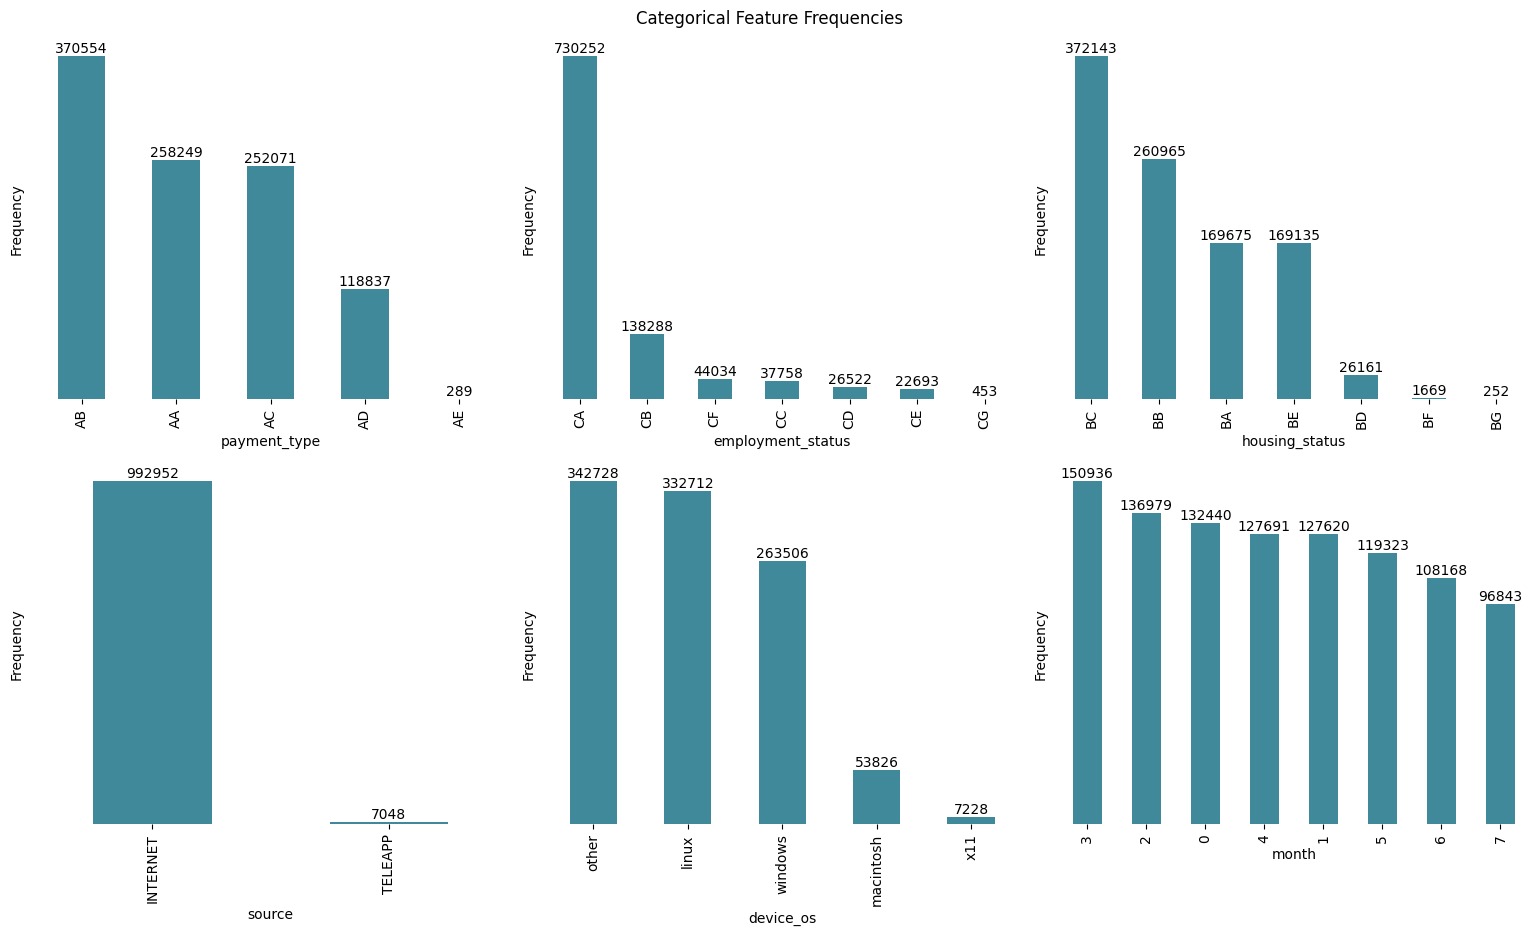

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15.5,9.5))

cats.append("month")

for i, cat in enumerate(cats):
    ax = axes[i // 3][i % 3]
    ax = df_master[cat].value_counts().plot(kind="bar", ax = ax, color = blue)
    ax.set_xlabel(cat)
    ax.set_ylabel("Frequency")
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticklabels(df_master[cat].value_counts().index)

    rects = ax.patches

    # Make some labels.
    labels = df_master[cat].value_counts()

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
fig.suptitle("Categorical Feature Frequencies")
#fig.delaxes(axes[-1,-1])
fig.tight_layout()


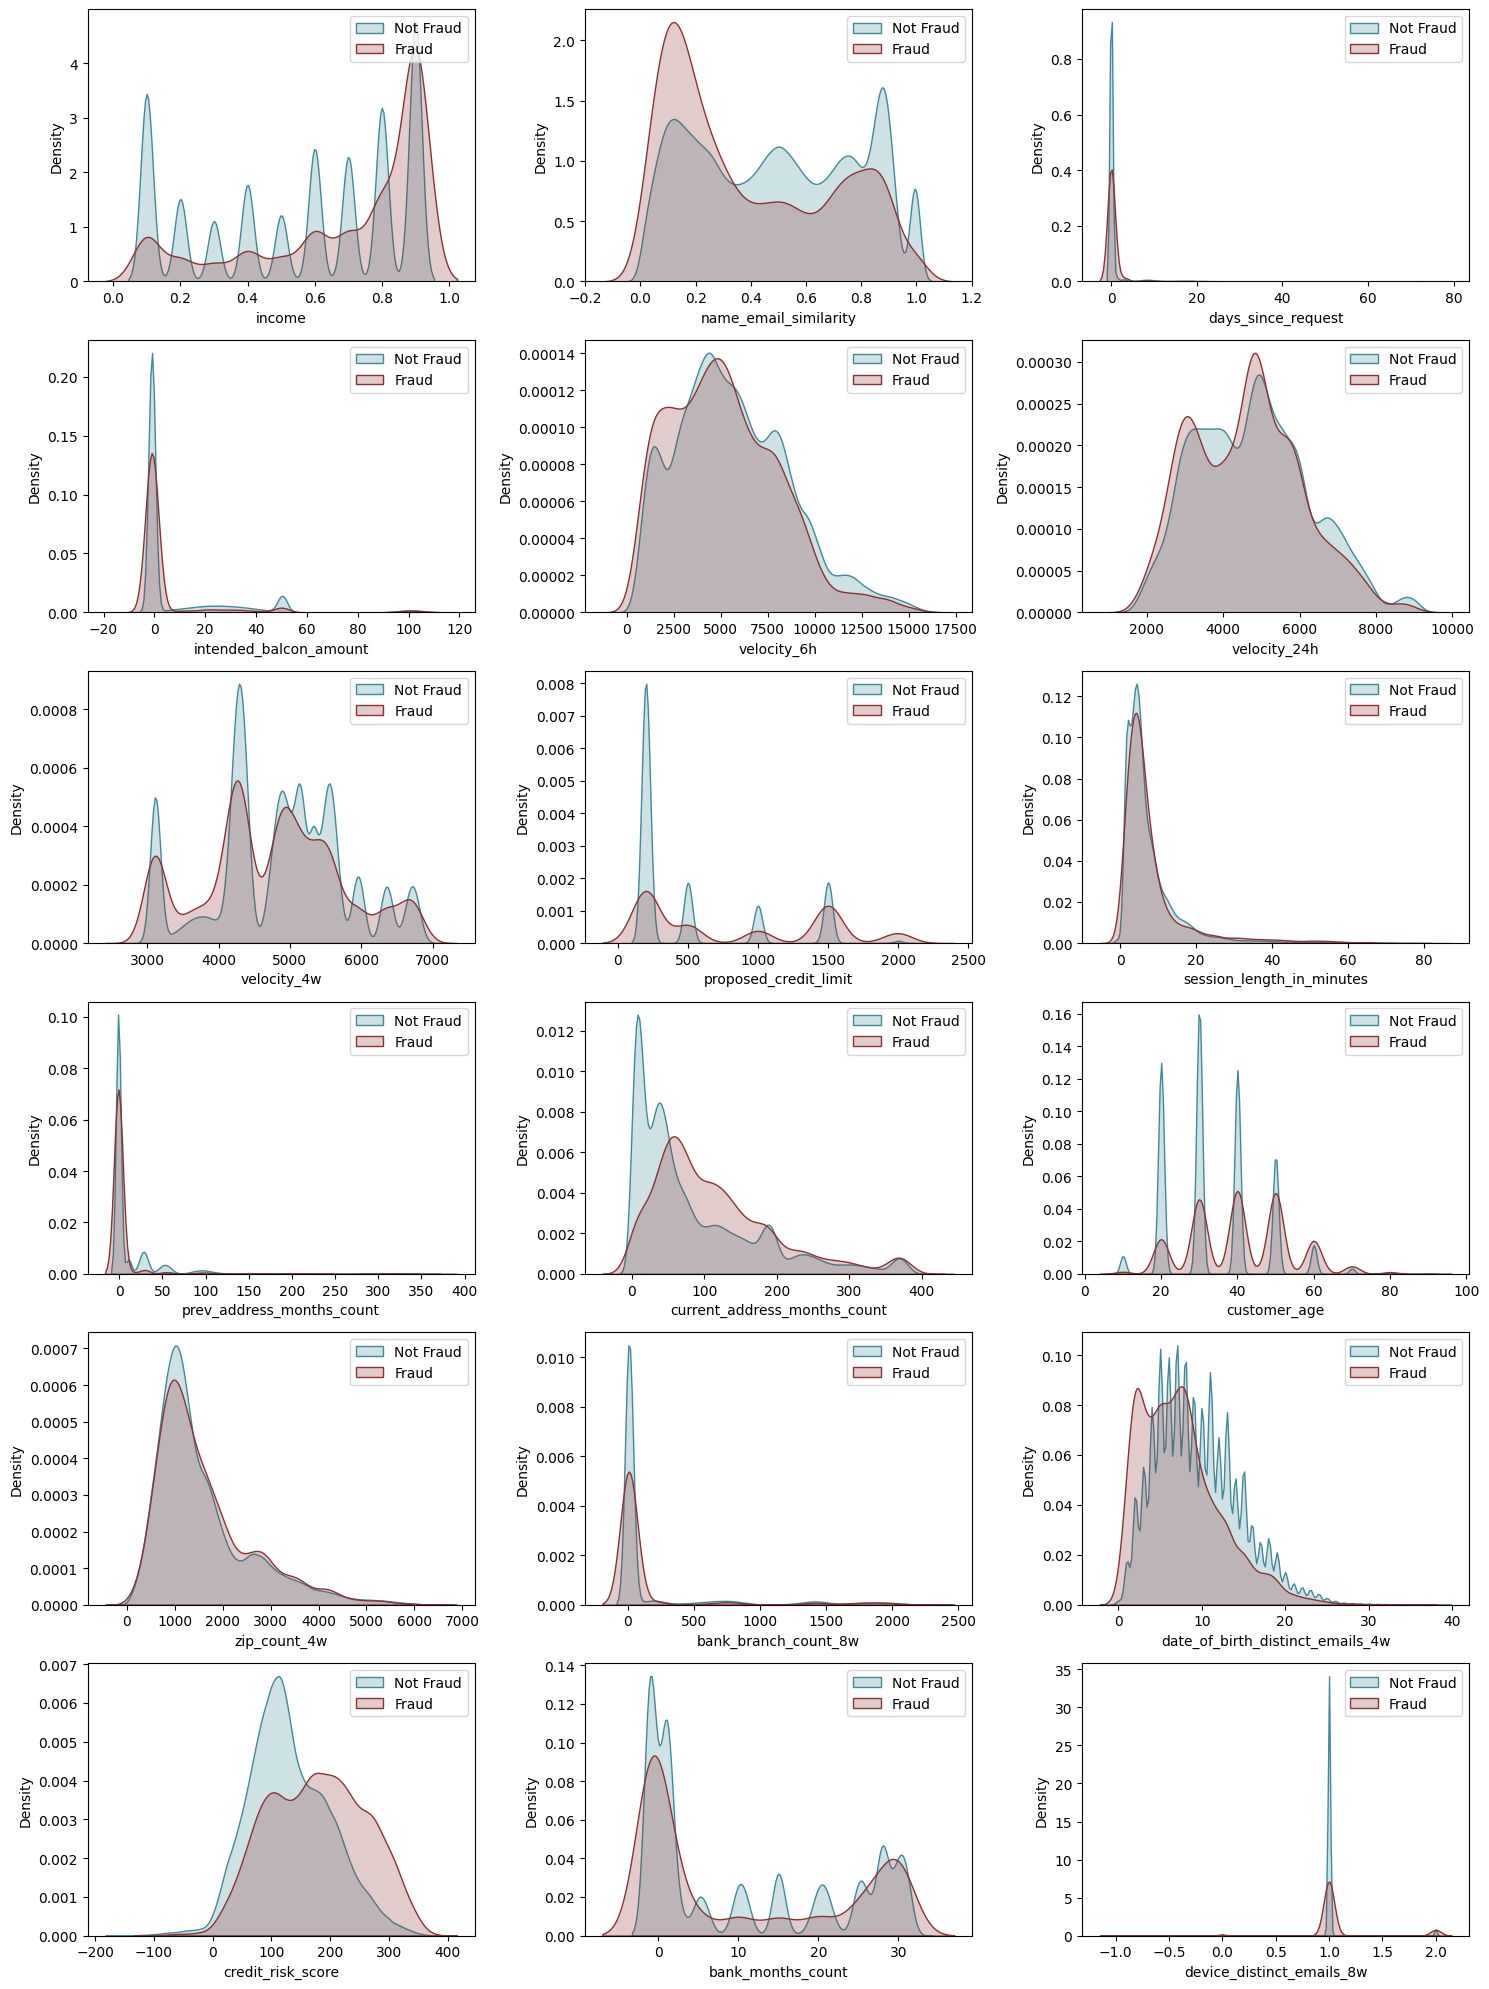

In [12]:

# Create a grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))

# Add a title to the figure
#fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(nums + counts):
    if i >= 6 * 3: break #don't want month plotted
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df_master[df_master['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud', color=blue)
    sns.kdeplot(data=df_master[df_master['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud', color=red)
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## Handle Missing Data

In [13]:
rand_state = 171827 # To make method comparison more fair

# Create training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(df_master.loc[:, df_master.columns != "fraud_bool"], df_master["fraud_bool"], random_state=rand_state) # Separate test set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=rand_state) # Create training and validation sets from remaining data

# Make a copy with target column for grouping in charts 
df = X_train.copy()
df["fraud_bool"] = y_train.copy()

The data set represents missing values with "-1" for the following columns:
<br>- current_address_months_count
<br>- session_length_in_minutes
<br>- device_distinct_emails_8w

In [14]:
from scipy.stats import chi2_contingency

In [15]:
# Features where -1 represents missing value
missing_feats = [
    "current_address_months_count",
    "session_length_in_minutes",
    "device_distinct_emails_8w"
]

### Check for Missing Randomness

In [16]:
a = .01
for feat in missing_feats:
    # Get Count of missing values for fraud vs non fraud
    miss = df[df[feat]==-1].groupby("fraud_bool")[feat].count()
    no_miss = df[df[feat]!=-1].groupby("fraud_bool")[feat].count()
    # Check for missing randomness
    chi2, p, dof, ex = chi2_contingency([[miss[0], no_miss[0]],[miss[1],no_miss[1]]])
    # Print results
    if p < a:
        print(f"{feat} missing NOT AT RANDOM, p = {p}")
    else: print(f"{feat} missing AT RANDOM, p = {p}")
    print(f"""
    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | {miss[0]}\t\t| {no_miss[0]}\t\t| {miss[0]/no_miss[0]}
    # Fraud     | {miss[1]}\t\t| {no_miss[1]}\t\t| {miss[1]/no_miss[1]}
    """)

current_address_months_count missing NOT AT RANDOM, p = 0.003677998419756962

    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | 2393		| 553959		| 0.004319814282284429
    # Fraud     | 11		| 6137		| 0.0017924067133778718
    
session_length_in_minutes missing AT RANDOM, p = 0.14939489035482426

    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | 1144		| 555208		| 0.0020604890419446405
    # Fraud     | 7		| 6141		| 0.0011398794984530207
    
device_distinct_emails_8w missing AT RANDOM, p = 0.6407905171335595

    #           | Missing (True)  | Not Missing (False) | Ratio Miss/No Miss
    # No Fraud  | 199		| 556153		| 0.0003578152055279752
    # Fraud     | 1		| 6147		| 0.00016268098259313488
    


### Missing at Random

Because of the large size of our dataset and the small amount of instances with missing data for our 2 features we determined were missing at random, we can simply drop the instances that are missing these values. <br>Note: This is done in out "transform_df" func so we can easily do the same thing to future data.

### Missing Not At Random

**current address months count** is our only feature missing not at random. We will use the SKLearn Iterative Imputer to replace the missing values.

From SKLearn docs: "A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned."

In summary: values are imputed by multiple regression models using the other features as inputs.

## Data Transformations

Categorical Data: One hot encoded
<br>Numeric Data:
<br>- If skewed: Log transformed
<br>- All Numeric Data: Min-Max Scaled

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.impute import IterativeImputer
import importlib
from sklearn import set_config

Note: All missingness and transformations handled in function below
<br> Here we also split data in to training, validation, and test sets.

In [18]:
# Create training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(df_master.loc[:, df_master.columns != "fraud_bool"], df_master["fraud_bool"], random_state=rand_state) # Separate test set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify = X_train[["customer_age"]], random_state=rand_state) # Create training and validation sets from remaining data

# Make a copy with target column for grouping in charts 
df = X_train.copy()
df["fraud_bool"] = y_train.copy()

# Define our cols by type
one_hot_cols = [
        "payment_type", "employment_status", "housing_status",
        "source", "device_os"
    ]
skewed_cols = [
    "days_since_request", "intended_balcon_amount", "proposed_credit_limit",
    "current_address_months_count", "prev_address_months_count",
    "zip_count_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
    "bank_months_count"
]
std_cols = [
    "session_length_in_minutes", "velocity_6h", "velocity_24h", "device_distinct_emails_8w", "credit_risk_score"
]
minmax_cols = [
    "income", "name_email_similarity", "velocity_4w", "customer_age", "month"
]

# Fit OHE on training data
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
ohe.fit(np.array(X_train[one_hot_cols]))

# Fit imputer on training data
imputer  = IterativeImputer(random_state=42)
num_cols = skewed_cols + std_cols + minmax_cols
X_train.loc[X_train["current_address_months_count"]==-1,"current_address_months_count"] = np.nan #Only column we want imputed
imputer.fit(X_train.loc[:,num_cols])

# Fit scalers to training data
log_cols = ["session_length_in_minutes"]
X_train[log_cols] = np.log(X_train[log_cols] + 2)
mm_scaler = MinMaxScaler().fit(X_train[minmax_cols + std_cols + skewed_cols])
pw_tranformer = PowerTransformer().fit(X_train[skewed_cols])
#std_scaler = StandardScaler().fit(df[std_cols]) # IF UNCOMMENT THE UN COMMENT IN FUNCS ALSO

#Transform all data sets
importlib.reload(funcs)
df_list = [X_train, X_valid, X_test]
target_list = [y_train, y_valid, y_test]
df_list_transformed = list()
for i, df in enumerate(df_list):
    y = target_list[i]
    df["target"] = y
    df_transformed = funcs.transform_df(
        df,
        imputer_fitted = imputer,
        ohe = ohe,
        #std_scaler = std_scaler,
        std_scaler = None,
        power_transformer = pw_tranformer,
        min_max_scaler = mm_scaler,
        do_log_transform = (i != 0) # X_train done before fitting scalers
        )
    df_list_transformed.append(df_transformed)
df_list_transformed[0].describe().T


c:\Users\Dylan\Documents\OU\DSA5900\Steimel_OUDSA5900\funcs.py:62: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,num_cols] = imputer_fitted.transform(df.loc[:,num_cols])
c:\Users\Dylan\Documents\OU\DSA5900\Steimel_OUDSA5900\funcs.py:62: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,num_cols] = imputer_fitted.transform(df.loc[:,num_cols])
c:\Users\Dylan\Documents\OU\DSA5900\Steimel_OUDSA5900\funcs.py:62: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a ne

,count,mean,std,min,25%,50%,75%,max
income,562303.0,0.578682,0.362863,0.000000,0.250000,0.625000,0.875000,1.0
name_email_similarity,562303.0,0.493974,0.288993,0.000000,0.225602,0.493001,0.755450,1.0
prev_address_months_count,562303.0,0.046068,0.114452,0.000000,0.000000,0.000000,0.033854,1.0
current_address_months_count,562303.0,0.204468,0.207780,-0.252935,0.047059,0.124706,0.305882,1.0
customer_age,562303.0,0.296064,0.150392,0.000000,0.125000,0.250000,0.375000,1.0
days_since_request,562303.0,0.013110,0.068602,0.000000,0.000092,0.000193,0.000336,1.0
intended_balcon_amount,562303.0,0.188207,0.157510,0.000000,0.111671,0.114399,0.158648,1.0
zip_count_4w,562303.0,0.235397,0.150716,0.000000,0.133633,0.188914,0.290936,1.0
velocity_6h,562303.0,0.345212,0.178493,0.000000,0.213065,0.324887,0.464767,1.0
velocity_24h,562303.0,0.422972,0.180214,0.000000,0.279667,0.420516,0.542677,1.0


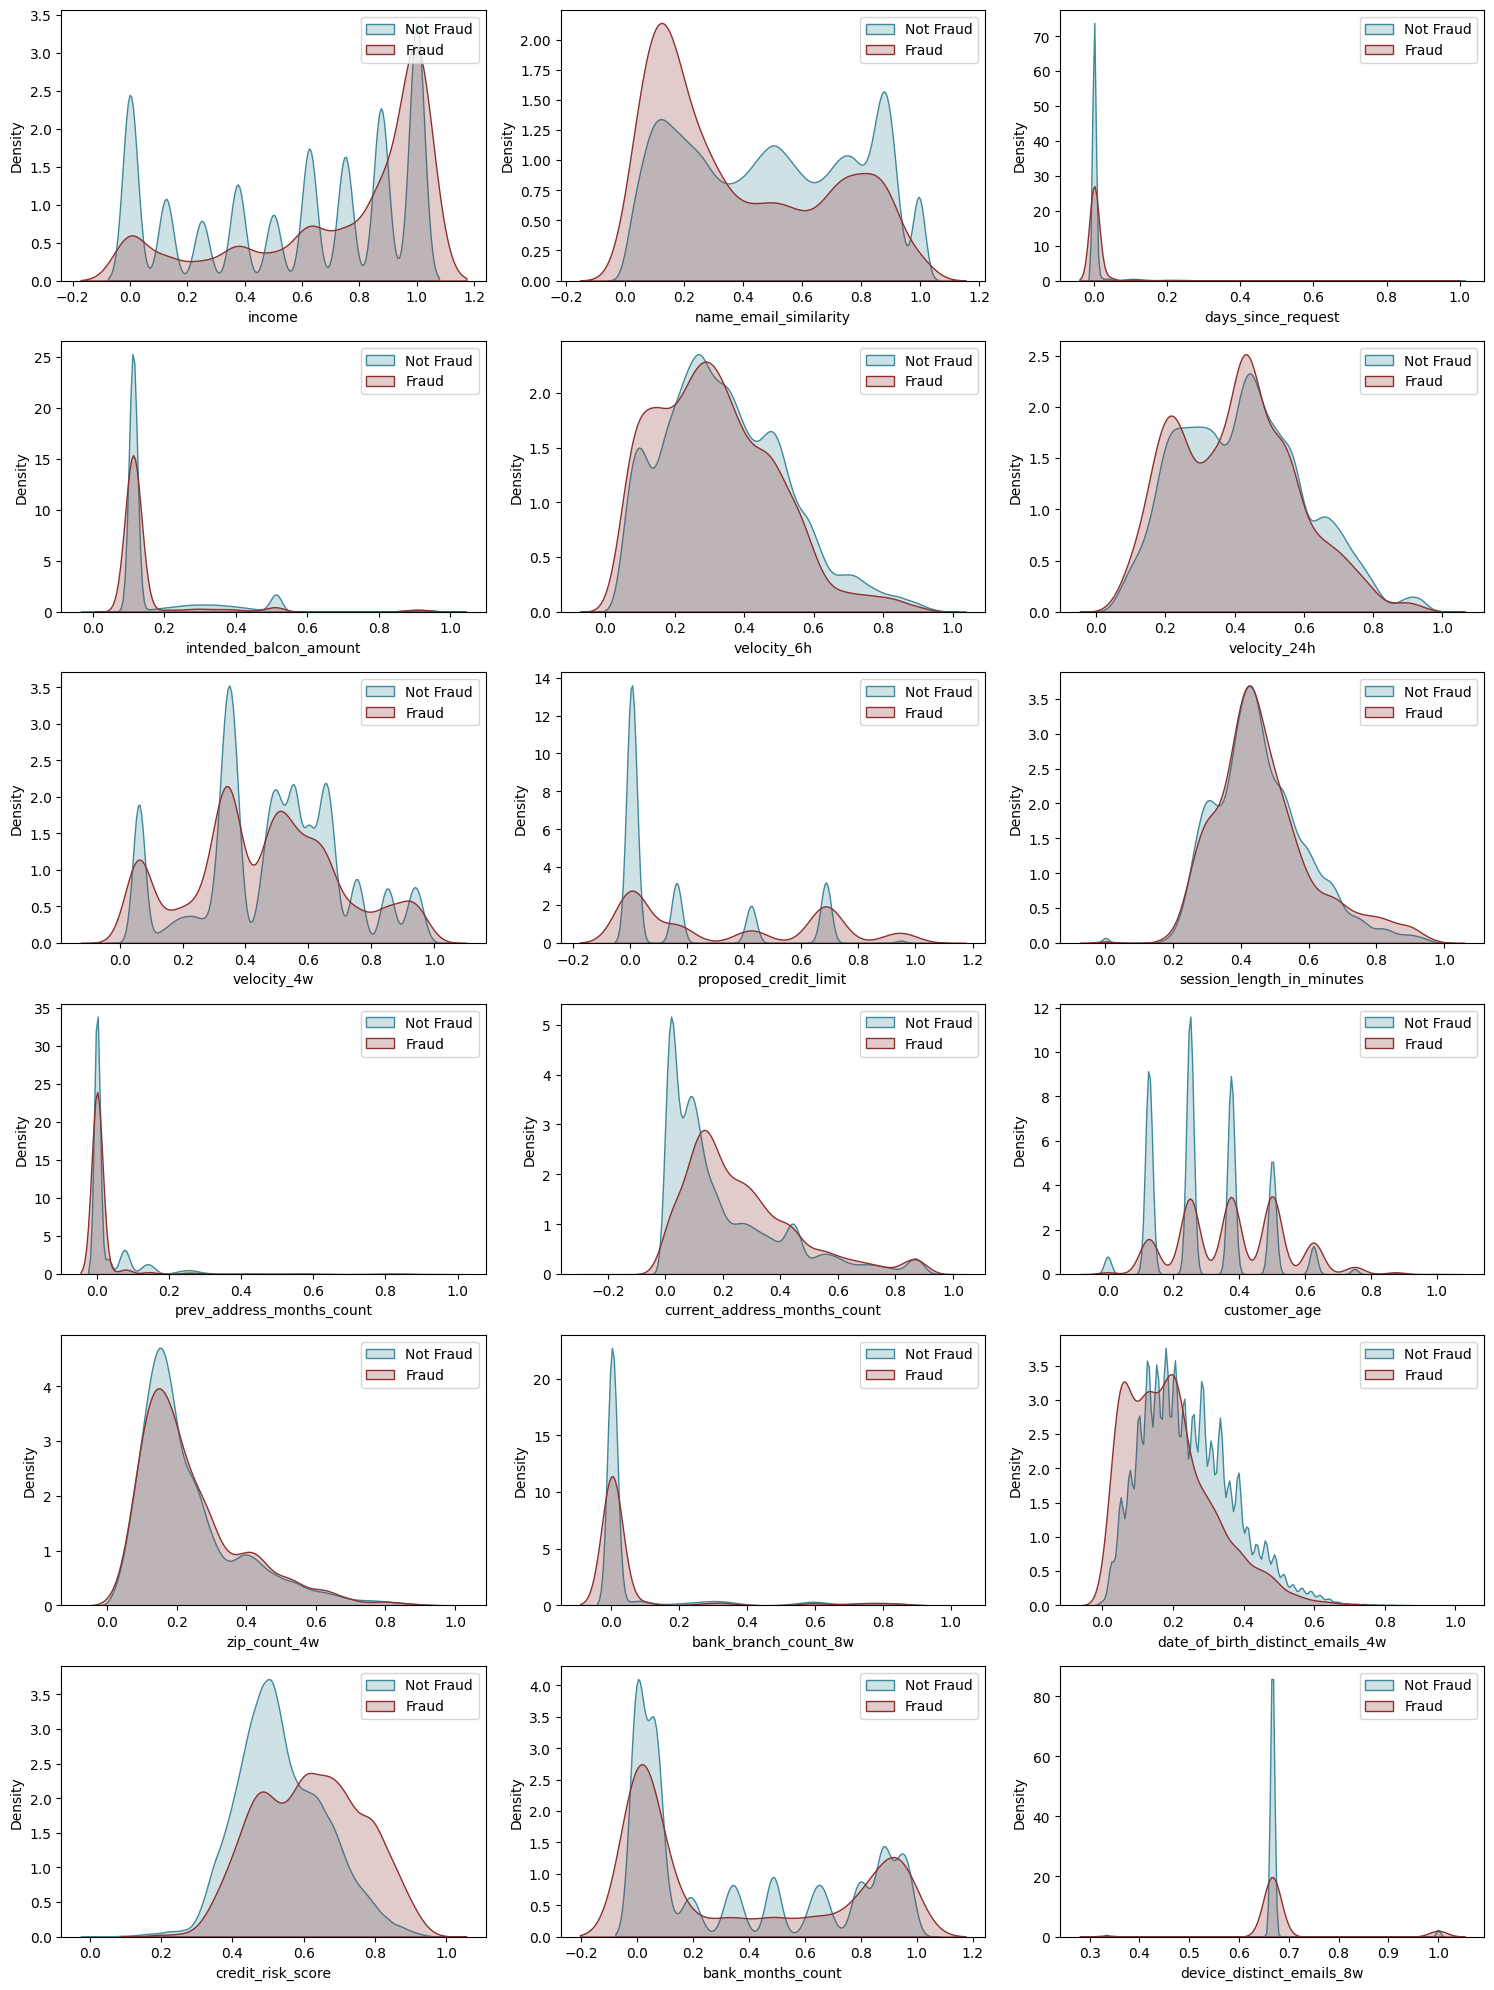

In [19]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))

# Add a title to the figure
#fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(nums + counts):
    if i >= 6 * 3: break #don't want month plotted
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df_list_transformed[0][df_list_transformed[0]['target'] == 0][feature], fill=True, ax=ax, label='Not Fraud', color=blue)
    sns.kdeplot(data=df_list_transformed[0][df_list_transformed[0]['target'] == 1][feature], fill=True, ax=ax, label='Fraud', color=red)
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [20]:
df_transformed

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
100847,0.000,0.139816,0.078125,0.007059,0.000,0.011792,0.195575,0.216030,0.106848,0.486422,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
474455,0.750,0.730038,0.031250,0.016471,0.250,0.000032,0.118204,0.202397,0.620083,0.492252,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8137,0.125,0.068261,0.000000,0.098824,0.375,0.000124,0.112821,0.167940,0.531111,0.198989,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
540363,1.000,0.282929,0.000000,0.089412,0.250,0.000102,0.113979,0.195805,0.053575,0.203791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
589908,0.750,0.153627,0.093750,0.032941,0.500,0.000339,0.880307,0.151311,0.194748,0.181837,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251348,0.125,0.816797,0.072917,0.030588,0.125,0.123743,0.509114,0.184120,0.544426,0.681073,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
783037,0.625,0.184774,0.000000,0.131765,0.250,0.000039,0.109895,0.406891,0.081610,0.337299,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
929830,1.000,0.028303,0.000000,0.094118,0.375,0.000050,0.861553,0.266517,0.245807,0.519382,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
638031,0.625,0.993483,0.000000,0.025882,0.125,0.000420,0.112555,0.152060,0.555771,0.703720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Store transformed data as variables
X_train_transformed, X_valid_transformed, X_test_transformed = [df.loc[:, df.columns != "target"] for df in df_list_transformed]
y_train_transformed, y_valid_transformed, y_test_transformed = [df["target"] for df in df_list_transformed]

## Modeling

In [22]:
import scipy.stats.distributions as dist
import scipy.stats as stats
import itertools
from sklearn.metrics import log_loss
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [23]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

DEFAULT_HIDDEN_LAYERS = [
  Dense(13, activation='relu')
]

def make_model(
  metrics=METRICS,
  output_bias=None,
  X_train = X_train_transformed.values,
  hlayer1 = None,
  hidden_layers = DEFAULT_HIDDEN_LAYERS,
  outlayer = None,
  outsize = 1,
  opt = "adam",
  loss = keras.losses.BinaryCrossentropy()
  ):
  """Make a tensorflow model with given inputs"""
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential()
  # Add first hidden layer
  if hlayer1 is None:
    model.add(Dense(np.rint(X_train.shape[-1] * (2/ 3)), input_dim=X_train.shape[-1], activation='relu'))
  else: model.add(hlayer1)
  # Add middle hidden layers
  for layer in hidden_layers:
    print("adding layer:", layer)
    model.add(layer)
  # Add output layer
  if outlayer is None:
    model.add(
        Dense(
          outsize, 
          activation='sigmoid',
          bias_initializer=output_bias
        )
    )
  else: model.add(outlayer)
  # Compile model
  model.compile(
      optimizer=opt,
      loss=loss,
      metrics=metrics)

  return model

### Imbalanced Data Technique Tests

In [24]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [25]:
model = make_model()
model.summary()

adding layer: <keras.layers.core.dense.Dense object at 0x0000017FB4F5EC50>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 31)                1457      
                                                                 
 dense (Dense)               (None, 13)                416       


                                                                 
 dense_2 (Dense)             (None, 1)                 14        
                                                                 
Total params: 1,887
Trainable params: 1,887
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Test Run
model.predict(X_train_transformed.values[:10])

1/1 [==============================] - 0s 201ms/step


array([[0.14499643],
       [0.1268211 ],
       [0.1576449 ],
       [0.15445277],
       [0.13096488],
       [0.13751039],
       [0.12826386],
       [0.14359272],
       [0.11927991],
       [0.10354128]], dtype=float32)

In [27]:
results = model.evaluate(
    X_train_transformed.values,
    y_train_transformed.values,
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1669


#### Output Bias

In [28]:
pos = sum(y_train_transformed)
neg = len(y_train_transformed) - pos
total = pos + neg
initial_bias = np.log([pos / neg]) # Output bias

In [29]:
# Now make model with output bias
model = make_model(output_bias = initial_bias)
model.predict(X_train_transformed.values[:10])

adding layer: <keras.layers.core.dense.Dense object at 0x0000017FB4F5EC50>
1/1 [==============================] - 0s 38ms/step


array([[0.01048992],
       [0.00965722],
       [0.01300956],
       [0.01189499],
       [0.01142036],
       [0.00939521],
       [0.00911373],
       [0.01075378],
       [0.01878563],
       [0.0081894 ]], dtype=float32)

In [30]:
results = model.evaluate(
    X_train_transformed.values,
    y_train_transformed.values,
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0622


In [31]:
import tempfile

In [32]:
# Save weights for fair comparison
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

#### Confirm bias helps

In [33]:
val_data = (
    X_valid_transformed.values,
    y_valid_transformed.values
)

In [34]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

adding layer: <keras.layers.core.dense.Dense object at 0x0000017FB4F5EC50>


In [35]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

adding layer: <keras.layers.core.dense.Dense object at 0x0000017FB4F5EC50>


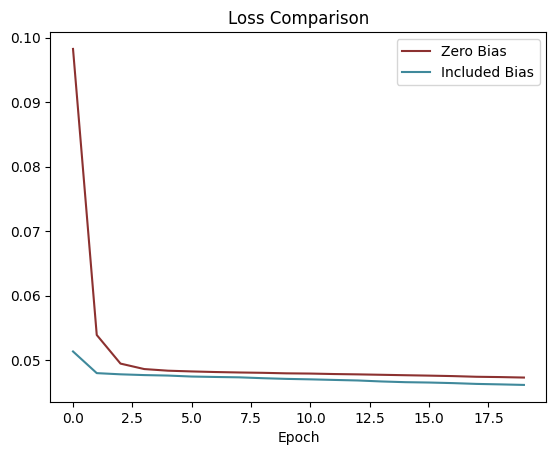

In [36]:
plt.plot(range(len(zero_bias_history.history["loss"])),zero_bias_history.history["loss"], label = "Zero Bias", color = red)
plt.plot(range(len(careful_bias_history.history["loss"])),careful_bias_history.history["loss"], label = "Included Bias", color = blue)
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [37]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_data)

adding layer: <keras.layers.core.dense.Dense object at 0x0000017FB4F5EC50>
Epoch 1/100
275/275 [==============================] - 2s 4ms/step - loss: 0.0513 - tp: 51.0000 - fp: 30.0000 - tn: 741091.0000 - fn: 8231.0000 - accuracy: 0.9890 - precision: 0.6296 - recall: 0.0062 - auc: 0.8347 - prc: 0.1048 - val_loss: 0.0470 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 185050.0000 - val_fn: 2047.0000 - val_accuracy: 0.9891 - val_precision: 0.6667 - val_recall: 9.7609e-04 - val_auc: 0.8628 - val_prc: 0.1303
Epoch 2/100
275/275 [==============================] - 1s 2ms/step - loss: 0.0479 - tp: 11.0000 - fp: 1.0000 - tn: 556069.0000 - fn: 6222.0000 - accuracy: 0.9889 - precision: 0.9167 - recall: 0.0018 - auc: 0.8552 - prc: 0.1242 - val_loss: 0.0467 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 185050.0000 - val_fn: 2049.0000 - val_accuracy: 0.9890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8645 - val_prc: 0.1350
Epoch 3/100
275/275 [==============================] - 1

In [38]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=blue, label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=red, linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

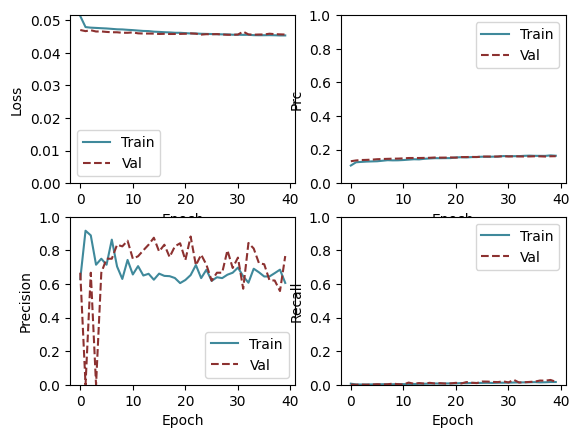

In [39]:
plot_metrics(baseline_history)

In [40]:
train_predictions_baseline = model.predict(X_train_transformed, batch_size=BATCH_SIZE)
valid_predictions_baseline = model.predict(X_valid_transformed, batch_size=BATCH_SIZE)

92/92 [==============================] - 0s 844us/step


In [41]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0455818772315979
tp :  41.0
fp :  18.0
tn :  185033.0
fn :  2008.0
accuracy :  0.98917156457901
precision :  0.694915235042572
recall :  0.020009761676192284
auc :  0.8692077994346619
prc :  0.1604006290435791

Legitimate Transactions Detected (True Negatives):  185033
Legitimate Transactions Incorrectly Detected (False Positives):  18
Fraudulent Transactions Missed (False Negatives):  2008
Fraudulent Transactions Detected (True Positives):  41
Total Fraudulent Transactions:  2049


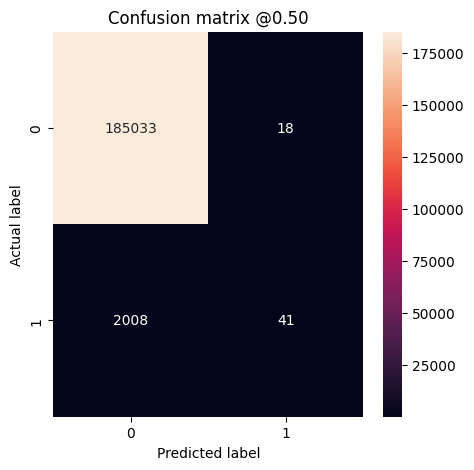

In [42]:
baseline_results = model.evaluate(
  X_valid_transformed,
  y_valid_transformed,
  batch_size=BATCH_SIZE,
  verbose=0
)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_valid_transformed, valid_predictions_baseline)

In [43]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,40])
  plt.ylim([60,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

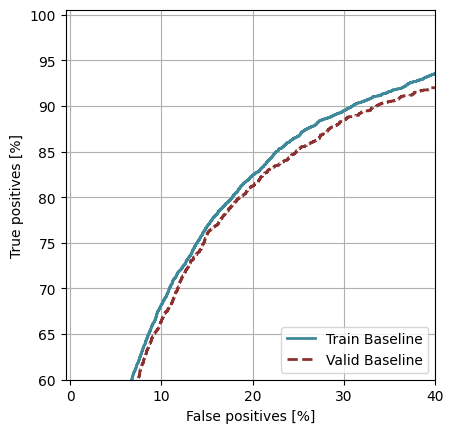

In [44]:
plot_roc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_roc("Valid Baseline", y_valid_transformed, valid_predictions_baseline, color=red, linestyle='--')
plt.legend(loc='lower right')

In [45]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

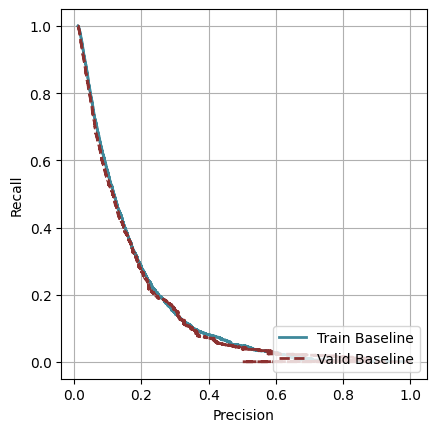

In [46]:
plot_prc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_prc("Valid Baseline", y_valid_transformed, valid_predictions_baseline, color=red, linestyle='--')
plt.legend(loc='lower right')

#### Class Weights

In [47]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 45.11


In [48]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train_transformed,
    y_train_transformed,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_data,
    # The class weights go here
    class_weight=class_weight)

adding layer: <keras.layers.core.dense.Dense object at 0x0000017FB4F5EC50>
Epoch 1/100
275/275 [==============================] - 2s 4ms/step - loss: 0.7378 - tp: 3615.0000 - fp: 123463.0000 - tn: 617658.0000 - fn: 4667.0000 - accuracy: 0.8290 - precision: 0.0284 - recall: 0.4365 - auc: 0.6650 - prc: 0.0490 - val_loss: 0.4502 - val_tp: 1619.0000 - val_fp: 36875.0000 - val_tn: 148176.0000 - val_fn: 430.0000 - val_accuracy: 0.8006 - val_precision: 0.0421 - val_recall: 0.7901 - val_auc: 0.8699 - val_prc: 0.1243
Epoch 2/100
275/275 [==============================] - 1s 2ms/step - loss: 0.4581 - tp: 4843.0000 - fp: 111849.0000 - tn: 444221.0000 - fn: 1390.0000 - accuracy: 0.7986 - precision: 0.0415 - recall: 0.7770 - auc: 0.8660 - prc: 0.1183 - val_loss: 0.4096 - val_tp: 1575.0000 - val_fp: 32554.0000 - val_tn: 152497.0000 - val_fn: 474.0000 - val_accuracy: 0.8235 - val_precision: 0.0461 - val_recall: 0.7687 - val_auc: 0.8758 - val_prc: 0.1310
Epoch 3/100
275/275 [==========================

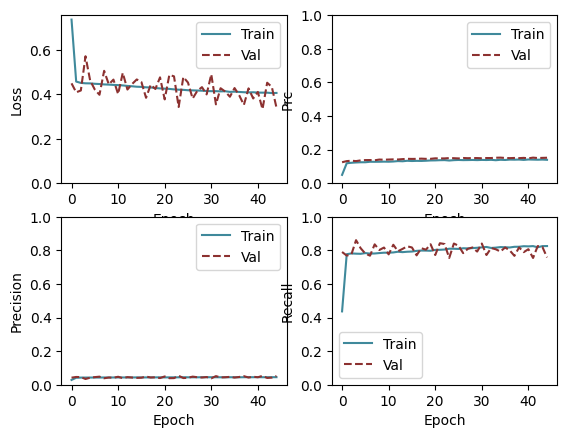

In [49]:
plot_metrics(weighted_history)

In [50]:
train_predictions_weighted = weighted_model.predict(X_train_transformed, batch_size=BATCH_SIZE)
valid_predictions_weighted = weighted_model.predict(X_valid_transformed, batch_size=BATCH_SIZE)

92/92 [==============================] - 0s 932us/step


loss :  0.38970187306404114
tp :  1624.0
fp :  33187.0
tn :  151864.0
fn :  425.0
accuracy :  0.8203527331352234
precision :  0.046651922166347504
recall :  0.7925817370414734
auc :  0.8850908279418945
prc :  0.15176400542259216

Legitimate Transactions Detected (True Negatives):  151864
Legitimate Transactions Incorrectly Detected (False Positives):  33187
Fraudulent Transactions Missed (False Negatives):  425
Fraudulent Transactions Detected (True Positives):  1624
Total Fraudulent Transactions:  2049


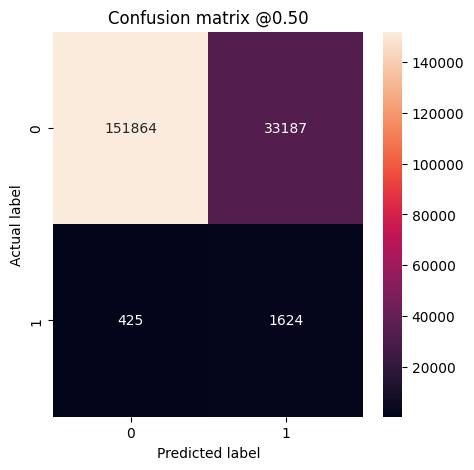

In [51]:
weighted_results = weighted_model.evaluate(X_valid_transformed, y_valid_transformed,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_valid_transformed, valid_predictions_weighted)

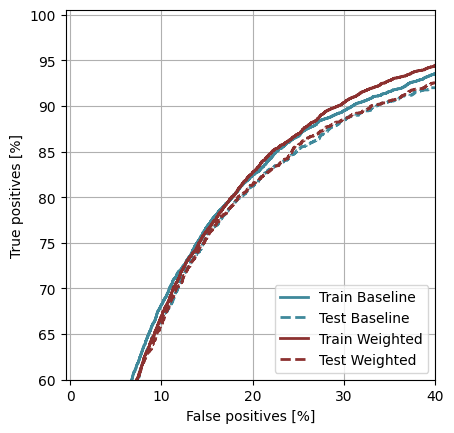

In [52]:
plot_roc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_roc("Test Baseline", y_valid_transformed, valid_predictions_baseline, color=blue, linestyle='--')

plot_roc("Train Weighted", y_train_transformed, train_predictions_weighted, color=red)
plot_roc("Test Weighted", y_valid_transformed, valid_predictions_weighted, color=red, linestyle='--')

plt.legend(loc='lower right')

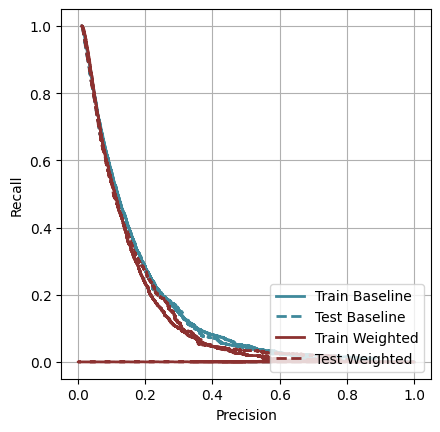

In [53]:
plot_prc("Train Baseline", y_train_transformed, train_predictions_baseline, color=blue)
plot_prc("Test Baseline", y_valid_transformed, valid_predictions_baseline, color=blue, linestyle='--')

plot_prc("Train Weighted", y_train_transformed, train_predictions_weighted, color=red)
plot_prc("Test Weighted", y_valid_transformed, valid_predictions_weighted, color=red, linestyle='--')

plt.legend(loc='lower right')

#### Over Sampling

In [54]:
# Over sample
bool_train_labels = y_train_transformed != 0
pos_features = X_train_transformed[bool_train_labels].values
neg_features = X_train_transformed[~bool_train_labels].values

pos_labels = y_train_transformed[bool_train_labels].values
neg_labels = y_train_transformed[~bool_train_labels].values

In [55]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(556070, 46)

In [56]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1112140, 46)

In [57]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [58]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [1.00000000e+00 2.08704366e-01 0.00000000e+00 5.48235294e-01
 6.25000000e-01 4.07415143e-04 1.11237851e-01 1.10711610e-01
 8.69070868e-02 2.62081262e-01 2.67121620e-01 0.00000000e+00
 1.02564103e-01 6.11111111e-01 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.62303665e-01
 0.00000000e+00 3.08889863e-01 0.00000000e+00 6.66666667e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00]

Label:  1


In [59]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [60]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

544.0

In [61]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_data)

adding layer: <keras.layers.core.dense.Dense object at 0x0000017FB4F5EC50>
Epoch 1/100
544/544 [==============================] - 13s 22ms/step - loss: 0.4684 - tp: 428274.0000 - fp: 151062.0000 - tn: 591839.0000 - fn: 130037.0000 - accuracy: 0.7840 - precision: 0.7392 - recall: 0.7671 - auc: 0.8654 - prc: 0.8232 - val_loss: 0.4350 - val_tp: 1624.0000 - val_fp: 35579.0000 - val_tn: 149472.0000 - val_fn: 425.0000 - val_accuracy: 0.8076 - val_precision: 0.0437 - val_recall: 0.7926 - val_auc: 0.8782 - val_prc: 0.1348
Epoch 2/100
544/544 [==============================] - 11s 21ms/step - loss: 0.4361 - tp: 443822.0000 - fp: 109938.0000 - tn: 446490.0000 - fn: 113862.0000 - accuracy: 0.7991 - precision: 0.8015 - recall: 0.7958 - auc: 0.8797 - prc: 0.8748 - val_loss: 0.4212 - val_tp: 1640.0000 - val_fp: 35030.0000 - val_tn: 150021.0000 - val_fn: 409.0000 - val_accuracy: 0.8106 - val_precision: 0.0447 - val_recall: 0.8004 - val_auc: 0.8818 - val_prc: 0.1401
Epoch 3/100
544/544 [==============

In [62]:
train_predictions_resampled = resampled_model.predict(X_train_transformed, batch_size=BATCH_SIZE)
valid_predictions_resampled = resampled_model.predict(X_valid_transformed, batch_size=BATCH_SIZE)

92/92 [==============================] - 0s 877us/step


loss :  0.40548694133758545
tp :  1635.0
fp :  34969.0
tn :  150082.0
fn :  414.0
accuracy :  0.8108872175216675
precision :  0.04466724768280983
recall :  0.7979502081871033
auc :  0.8830340504646301
prc :  0.14658409357070923

Legitimate Transactions Detected (True Negatives):  150082
Legitimate Transactions Incorrectly Detected (False Positives):  34969
Fraudulent Transactions Missed (False Negatives):  414
Fraudulent Transactions Detected (True Positives):  1635
Total Fraudulent Transactions:  2049


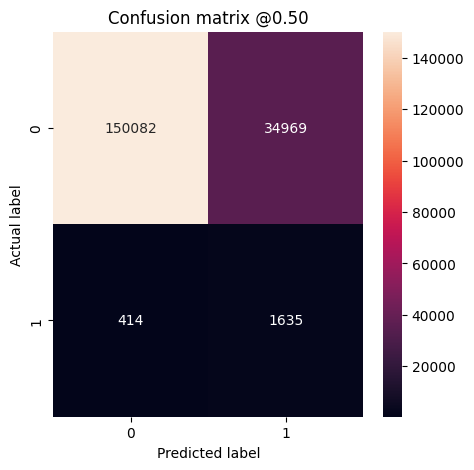

In [63]:
resampled_results = resampled_model.evaluate(X_valid_transformed, y_valid_transformed,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_valid_transformed, valid_predictions_resampled)

## Fairness

Beyond being a good classification model we want to make sure our model doesn't discriminate between groups. We will use the fairness metrics below to check the validity of the model with regard to fairness as iterate through hyper-parameters.

In [64]:
def get_disparity_df(model, X_val, prob_threshold=0.5):
    # Create pred df for easy comparisons
    y_pred = model.predict_proba(X_val)[:, 1]
    disparity_df = pd.DataFrame()
    disparity_df["true_label"] = y_valid_transformed
    disparity_df["pred_prob"] = y_pred
    # Get TP/TN/FP/FN
    disparity_df["pred_label"] = disparity_df["pred_prob"] > prob_threshold
    disparity_df["true_pos"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == True)
    disparity_df["true_neg"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == False)
    disparity_df["false_pos"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == True)
    disparity_df["false_neg"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == False)
    # Add in identifiers
    disparity_df["age"] = X_valid["customer_age"][disparity_df.index]
    disparity_df["income"] = X_valid["income"][disparity_df.index]
    disparity_df["employment_status"] = X_valid["employment_status"][disparity_df.index]
    return disparity_df

In [65]:
def get_parity_df(disparity_df, groups = ["age", "income", "employment_status"]):
    parity_df = pd.DataFrame(columns=["group", "group value","stat name", "value", "n samples", "pop value", "parity score", "has parity", "pval", "diff whole group"])
    i = 0
    for g in groups:
        for val in disparity_df[g].unique():
            sub = disparity_df[disparity_df[g] == val]
            pval, z, pop_fpr, group_fpr = get_fpr_fairness(disparity_df, sub)
            parity_df.loc[i] = [g,val,"fpr", group_fpr, len(sub), pop_fpr, z, pval > .01, pval, group_fpr - pop_fpr]
            i += 1   
    return parity_df

In [66]:
def get_disparity_df_tf(
    model,
    prob_threshold = 0.5,
    X_val = X_valid_transformed.values,
    y_val =y_valid_transformed,
    X_id_mat = X_valid,
    do_print=True
    ):
    # Create pred df for easy comparisons
    y_pred = model(X_val)
    disparity_df = pd.DataFrame()
    disparity_df["true_label"] = y_val
    disparity_df["pred_prob"] = y_pred
    # Get TP/TN/FP/FN
    disparity_df["pred_label"] = disparity_df["pred_prob"] > prob_threshold
    disparity_df["true_pos"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == True)
    disparity_df["true_neg"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == False)
    disparity_df["false_pos"] = (disparity_df['true_label'] == False) & (disparity_df['pred_label'] == True)
    disparity_df["false_neg"] = (disparity_df['true_label'] == True) & (disparity_df['pred_label'] == False)
    # Add in identifiers
    disparity_df["age"] = X_id_mat["customer_age"][disparity_df.index]
    disparity_df["income"] = X_id_mat["income"][disparity_df.index]
    disparity_df["employment_status"] = X_id_mat["employment_status"][disparity_df.index]
    if do_print: print(disparity_df)
    return disparity_df

#get_parity_df(get_disparity_df_tf(model_clf, do_print=False), groups=["age"])

In [67]:
def get_fpr_fairness(pop: pd.DataFrame, group: pd.DataFrame):
    np.seterr(all='ignore')
    # FPR = FP / FP + TN
    n1 = sum(pop["false_pos"]) + sum(pop["true_neg"])
    n2 = sum(group["false_pos"]) + sum(group["true_neg"]) 
    p1 = sum(pop["false_pos"]) / n1 # FP proportion for sample 1
    p2 = sum(group["false_pos"]) / n2 # FP proportion for sample 2
    p = (   # Proportion for combined samples
            (sum(pop["false_pos"]) + sum(group["false_pos"]))
            /(n1 + n2)
        )
    Z = (
        ((p1 - p2) - 0)
        / np.sqrt(p * (1-p) * ((1/n1)+(1/n2)))
    )
    pval = 2*dist.norm.cdf(-np.abs(Z))
    return pval, Z, p1, p2 #pval of difference, population fpr, group fpr

In [68]:
def get_min_samples(pop_proportion, z_stat = 1.96, err = 0.05):
    return ((z_stat / err)**2) * pop_proportion * (1 - pop_proportion)

In [69]:
def get_fpr_parity(disparity_dict, groups = ["age"]):
    fpr_dict = dict()
    for g in groups:
        values = sorted(disparity_dict[g].unique())
        fpr_dict[g] = {
            "pval" : list(),
            "z" : list()
        }
        for v in values:
            sample_1 = disparity_dict[disparity_dict[g]==v]
            pvals = list()
            zs = list()
            for v2 in values:
                sample_2 = disparity_dict[disparity_dict[g]==v2]
                pval, Z, p1, p2 = get_fpr_fairness(sample_1, sample_2)
                pvals.append(pval)
                zs.append(Z)
            fpr_dict[g]["pval"].append(pvals)
            fpr_dict[g]["z"].append(zs)
        fpr_dict[g]["pval"] = pd.DataFrame(fpr_dict[g]["pval"], values, values)
        fpr_dict[g]["z"] = pd.DataFrame(fpr_dict[g]["z"], values, values)
    return fpr_dict

In [70]:
def get_fpr_fairness_1(fp_pop, tn_pop, fp_sub, tn_sub):
    # FPR = FP / FP + TN
    n1 = fp_pop + tn_pop
    n2 = fp_sub + tn_sub 
    p1 = fp_pop / n1 # FP proportion for sample 1
    p2 = fp_sub / n2 # FP proportion for sample 2
    p = (   # Proportion for combined samples
            (fp_pop + fp_sub)
            /(n1 + n2)
        )
    Z = (
        ((p1 - p2) - 0)
        / np.sqrt(p * (1-p) * ((1/n1)+(1/n2)))
    )
    pval = 2*dist.norm.cdf(-np.abs(Z))
    return pval, Z, p1, p2 #pval of difference, population fpr, group fpr

In [71]:
def get_disparity_dict(disparity_df, ok_fpr_diff = .05):
    fairness_cats = ["age", "income", "employment_status"]

    disparity_dict = dict()
    for cat in fairness_cats:
        cat_metrics = list()
        for val in disparity_df[cat].unique():
            sub = disparity_df[disparity_df[cat]==val]
            n_instances = len(sub.index)
            sub_tpr = sum(sub["true_pos"]) / n_instances
            sub_fpr = sum(sub["false_pos"]) / n_instances
            cat_metrics.append([val, n_instances, sub_tpr, sub_fpr, sub])
        disparity_dict[cat] = cat_metrics

    for cat in fairness_cats:
        max_fpr = -1
        max_val = None
        max_n = None
        min_fpr = 1
        min_val = None
        min_n = None
        for i in range(len(disparity_dict[cat])):
            cat_val = disparity_dict[cat][i][0]
            cat_n = disparity_dict[cat][i][1]
            if cat_n < 1000: continue
            cat_tpr = disparity_dict[cat][i][2]
            cat_fpr = disparity_dict[cat][i][3]
            if cat_fpr < min_fpr:
                min_fpr = cat_fpr
                min_val = cat_val
                min_n = cat_n
            if cat_fpr > max_fpr:
                max_fpr = cat_fpr
                max_val = cat_val
                max_n = cat_n
        if max_fpr - min_fpr <= ok_fpr_diff:
            print(f"""{cat} category is fair!
            Max fpr: {max_fpr}
            Max value: {max_val}
            Max n: {max_n}
            Min fpr: {min_fpr}
            Min value: {min_val}
            Min_n: {min_n}
            Difference: {max_fpr - min_fpr}""")
        else:
            print(f"""{cat} category is NOT fair!
            Max fpr: {max_fpr}
            Max value: {max_val}
            Max n: {max_n}
            Min fpr: {min_fpr}
            Min value: {min_val}
            Min n: {min_n}
            Difference: {max_fpr - min_fpr}""")
        print("\n\n")

        return disparity_dict

In [72]:
def plot_fpr_by_cat(disparity_dict):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    # Loop through the numeric features and plot a kernel density plot for each feature
    for i, cat in enumerate(disparity_dict):
        ax = axes[i]
        ax.bar([x[0] for x in disparity_dict[cat]], 
                [x[3] for x in disparity_dict[cat]])
        ax.set_xlabel(cat)
        ax.set_ylabel("fpr")
    plt.show()

## Adversarial Debiasing

In this section we build and tune our models, iterating through hyper-parameters for the methods described above. As well as for debiasing.

In [73]:
import scipy.stats.distributions as dist
import scipy.stats as stats
import itertools
from sklearn.metrics import log_loss
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from fairlearn.metrics import equalized_odds_ratio, equalized_odds_difference, demographic_parity_ratio

### Build Model

In [74]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [75]:
# COPIED for less scrolling while debugging
def make_model(
  name,
  metrics=METRICS,
  output_bias=None,
  X_train = X_train_transformed.values,
  hlayer1 = None,
  hidden_layers = [Dense(13, activation='relu')],
  outlayer = None,
  outsize = 1,
  opt = "adam",
  loss = keras.losses.BinaryCrossentropy()
  ):
  """Make a tensorflow model with given inputs"""
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential(name=name)
  # Add first hidden layer
  if hlayer1 is None:
    model.add(Dense(np.rint(X_train.shape[-1] * (2/ 3)), input_dim=X_train.shape[-1], activation='relu'))
  else: model.add(hlayer1)
  # Add middle hidden layers
  for layer in hidden_layers:
    model.add(layer)
  # Add output layer
  if outlayer is None:
    model.add(
        Dense(
          outsize, 
          activation='sigmoid',
          bias_initializer=output_bias
        )
    )
  else: model.add(outlayer)
  # Compile model
  model.compile(
      optimizer=opt,
      loss=loss,
      metrics=metrics)

  return model

### Pretrain classifier

In [76]:
batch_size = 256
n_pretrain_epochs = 30
new_run = False # Set to true if pretrained models not saved

In [77]:
pos = sum(y_train_transformed)
neg = len(y_train_transformed) - pos
total = pos + neg
initial_bias = np.log([pos / neg]) # Output bias

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Initial output bias {initial_bias}")
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Initial output bias [-4.49103643]
Weight for class 0: 0.51
Weight for class 1: 22.55


In [78]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
    )


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def pretrain_classifier(
        model_name,
        class_weights,
        output_bias,
        hlayers,
        learning_rate,
        X_train,
        y_train,
        X_val,
        y_val,
        n_epochs = 200,
        callbacks = [reduce_lr, early_stopping]
        ):
    
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model = make_model(
                name=model_name,
                output_bias=output_bias,
                hidden_layers=hlayers,
                X_train=X_train,
                opt=opt
                )
        data_set = (X_val, y_val)
        

        history = model.fit(
                X_train,
                y_train,
                epochs=n_epochs,
                batch_size=256,
                class_weight=class_weights,
                validation_data = data_set,
                callbacks=callbacks
                )

        return model, history

In [79]:
def get_classifier_validity(
        history,
        best_epoch,
        min_recall = .4,
        min_precision = .035
    ):
    return ((history.history["val_recall"][best_epoch] >= min_recall) and (history.history["val_precision"][best_epoch] >= min_precision))
def get_classifier_validity_2(
        history,
        best_epoch,
        min_recall = .4,
        min_precision = .035
    ):
    return ((history["val_recall"][best_epoch] >= min_recall) and (history["val_precision"][best_epoch] >= min_precision))

In [80]:
if new_run:
    # Hyperparams to iterate over
    class_weights = [
        {0: weight_for_0, 1: weight_for_1},
        {0: weight_for_0, 1: weight_for_1 * .5},
        {0: weight_for_0, 1: weight_for_1 * .25},
        {0: weight_for_0, 1: weight_for_1 * .125},
        None
    ]
    output_bias = [
        initial_bias,
        None
    ]
    hlayers = [
        [Dense(13, activation='relu')],
        [Dense(13, activation='tanh')],
        [Dense(20, activation='relu'), Dense(10, activation='relu')],
    ]

    hidden_layers = [hlayers, hlayers1, hlayers2]
    learning_rate = [
        .1,
        .01,
        .001
    ]
    X_train = [
        X_train_transformed.values
    ]
    y_train = [y_train_transformed]
    names = ["Full", "No_Sensitive_Group", "PCA"]
    X_val = [
        X_valid_transformed.values
    ]
    y_val = [y_valid_transformed]

    all_params = [class_weights, output_bias, learning_rate, X_train, X_val, y_train, y_val]

    param_id = 0
    # Dict to store best parameters: lists represent [score, param_id, [params], model]
    best_params = {
        "Best Recall" : [-1, None, None, None],
        "Best Precision" : [-1, None, None, None],
        "Best AUC" : [-1, None, None, None],
        "Best Sum" : [-1, None, None, None]
    }
    combos = list(itertools.product(*all_params))
    print("TOTAL COMBINATIONS:", t := len(combos))
    for class_weights, output_bias, learning_rate, X_train, X_val, y_train, y_val in combos:
        current_params = [class_weights, output_bias, learning_rate, X_train, X_val, y_train, y_val]
        model, history = pretrain_classifier(
            "Full", # name
            class_weights,
            output_bias,
            [Dense(13, activation='relu')],
            learning_rate,
            X_train, # X train
            y_train,
            X_val, # X val
            y_val
        )

        if early_stopping.best_epoch == 0: best_epoch = len(history.history["val_precision"]) - 1
        else: best_epoch = early_stopping.best_epoch

        if get_classifier_validity(history, best_epoch):
            recall = history.history["val_recall"][best_epoch]
            prec = history.history["val_precision"][best_epoch]
            auc = history.history["val_auc"][best_epoch]
            s = recall + prec + auc

            if recall > best_params["Best Recall"][0]:
                best_params["Best Recall"] = [
                    recall,
                    param_id,
                    current_params,
                    model
                ]
            if prec > best_params["Best Precision"][0]:
                best_params["Best Precision"] = [
                    prec,
                    param_id,
                    current_params,
                    model
                ]
            if auc > best_params["Best AUC"][0]:
                best_params["Best AUC"] = [
                    auc,
                    param_id,
                    current_params,
                    model
                ]
            if s > best_params["Best Sum"][0]:
                best_params["Best Sum"] = [
                    s,
                    param_id,
                    current_params,
                    model
                ]
            
        param_id += 1
        print(f"ITER {param_id} / {t}")

In [81]:
if new_run: # Save best models
    for key in best_params:
        best_params[key][-1].save(f"{key.replace(' ', '')}Model.mdl")    

In [82]:
def print_cm(tn, fp, fn, tp):
    print(f"tn: {tn}\tfp:{fp}")
    print(f"fn: {fn}\ttp: {tp}")

def get_performance_metrics_by_hist(history, epoch = -1):
    #loss = history["val_loss"]
    tp = history["val_tp"]
    fp = history["val_fp"]
    tn = history["val_tn"]
    fn = history["val_fn"]
    #acc = history["val_accuracy"]
    prec = history["val_precision"]
    recall = history["val_recall"]
    auc = history["val_auc"]
    #prc = history["val_prc"]
    print_cm(tn[epoch], fp[epoch], fn[epoch], tp[epoch])
    print(f"recall: {recall[epoch]}\tprecision: {prec[epoch]}\tauc: {auc[epoch]}")

In [83]:
if new_run:
    colors = [red, blue, "darkgreen"]
    i = 0
    keys = ["Best AUC", "Best Recall", "Best Precision"]
    lines = list()
    for key in keys:
        model = best_params[key][-1]
        r = range(len(model.history.history["loss"]))
        
        p = plt.plot(r, model.history.history["prc"], color = colors[i], label = f"{key} Train")
        pv = plt.plot(r, model.history.history["val_prc"], "--",color = colors[i], label = f"{key} Valid")
        i += 1
        lines.append((p, pv))
    plt.title("Area under Precision Recall Curve (PRC)")
    plt.xlabel("Epochs")
    plt.legend()
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

In [84]:
loaded_model = tf.keras.models.load_model('BestAUCModel.mdl')

In [85]:
model_clf = loaded_model

In [86]:
if new_run:
    model_adv = Sequential()
    model_adv.add(Dense(15, input_dim=1, activation='relu'))
    #model_adv.add(Dense(25, activation='relu'))
    model_adv.add(Dense(9, activation='softmax'))

    # optimizer
    opt_adv = tf.keras.optimizers.Adam(learning_rate=0.01)

    # compile the keras model
    model_adv.compile(loss='categorical_crossentropy', optimizer=opt_adv)

    # Get income targets
    incomes = np.unique(X_train_transformed["customer_age"])
    y_income = pd.DataFrame()
    y_income["target"] = X_train_transformed["customer_age"].copy()
    for val in incomes:
        y_income[f"age_{val}"] = (y_income["target"] == val).astype(int)
    cols = y_income.columns.tolist()
    cols.remove("target")

    y_adv = y_income[cols].values
    print("Getting clf predictions")
    X_adv = model_clf(X_train_transformed.values)

    reduce_lr_adv = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.2,
        patience=5,
        verbose=1
        )


    early_stopping_adv = tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        verbose=1,
        patience=10,
        mode='min',
        restore_best_weights=True
        )

    history_adv = model_adv.fit(X_adv, y_adv,
                                epochs=n_pretrain_epochs,
                                batch_size=256,
                                callbacks=[early_stopping_adv, reduce_lr_adv]
                                )

In [87]:
if new_run:
    model_adv.save('pretrained_adv.mdl')
    model_clf.save('pretrained_clf.mdl')

### Perform Desbiasing

In [88]:
model_adv = tf.keras.models.load_model('pretrained_adv.mdl')
model_clf = tf.keras.models.load_model('pretrained_clf.mdl')

In [89]:
def is_valid_debiased_model(recall, precision, z_score):
    return (recall >= .4) and (precision >= .035) and (z_score < 3)

In [90]:
def get_significant_max_diff(disparity_dict, alpha = .01):
    # Determine min sample size to be significant
    fp = sum(disparity_dict["false_pos"])
    tn = sum(disparity_dict["true_neg"])
    fpr = fp / (fp + tn)
    min_samples = get_min_samples(fpr, err=0.01)
    # Get pvals for diff between fpr of all groups
    par_df = get_parity_df(disparity_dict,["age"])
    fpp = get_fpr_parity(disparity_dict)["age"]["pval"]
    max_diff = 0
    for x in fpp:
        x_fp = sum(disparity_dict[disparity_dict["age"]==x]["false_pos"])
        x_tn = sum(disparity_dict[disparity_dict["age"]==x]["true_neg"])
        if x_fp + x_tn < min_samples: break # x sample to small
        for y in fpp.columns:
            y_fp = sum(disparity_dict[disparity_dict["age"]==y]["false_pos"])
            y_tn = sum(disparity_dict[disparity_dict["age"]==y]["true_neg"])
            if y_fp + y_tn < min_samples: break # y sample too small
            elif fpp[x][y] < alpha: # Not statistically equal, pval < alpha
                diff = np.abs(par_df[par_df["group value"] == x]["value"].values[0] - par_df[par_df["group value"] == y]["value"].values[0])
                max_diff = max(diff, max_diff)
    return max_diff

In [91]:
def projection(u, v):
    u_dot_v = tf.reduce_sum(u * v)
    v_dot_v = tf.reduce_sum(v * v)
    proj = (u_dot_v / v_dot_v) * v
    return proj

# 0: 0.5056573130505786, 1: 11.172647432840566 # Class weights for Best AUC Model

def create_weighted_binary_crossentropy(class_weights):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        bce = keras.losses.BinaryCrossentropy()
        b_ce = bce(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return tf.math.reduce_mean(weighted_b_ce)
    return weighted_binary_crossentropy

def debias(alpha, lr_clf, lr_adv, decay, decay_step, X_clf, y_clf, X_clf_val, y_clf_val, y_adv, metrics, class_weights):
    # Store params
    params = {
        "a": alpha,
        "lr_clf": lr_clf,
        "lr_adv": lr_adv,
        "decay": decay,
        "decay_step" : decay_step,
        "class_weights" : class_weights
    }
    # Where to track metrics
    change_thresh = .00001
    invalid_epochs = 0
    history = dict([(m.name, list()) for m in metrics])
    history_valid = dict([(f"val_{m.name}", list()) for m in metrics])
    parity_hist = {
        "avg_z" : list(),
        "max_z" : list(),
        "n_groups" : list(),
        "max_diff" : list(),
        "sig_diff" : list(),
        "is_valid" : list()
    }
    best_z = 50
    best_n_groups = 0
    best_z_avg = 50
    best_weights = {
        "Best Z max" : list(),
        "Best Z avg" : list(),
        "Best n groups" : list()
    }
    ws = list()
    clf_losses = list()
    adv_losses = list()
    last_clf_loss = 0
    last_adv_loss = 0
    last_max_z = 0
    no_change_count = 0
    # Load in clean models
    model_adv = tf.keras.models.load_model('pretrained_adv.mdl')
    model_clf = tf.keras.models.load_model('pretrained_clf.mdl')
    optimizer_clf = tf.keras.optimizers.Adam(learning_rate=lr_clf)
    optimizer_adv = tf.keras.optimizers.Adam(learning_rate=lr_adv)
    # Iterate over the batches of a dataset.
    bce = keras.losses.BinaryCrossentropy()
    cce = keras.losses.CategoricalCrossentropy()
    clf_loss_func = create_weighted_binary_crossentropy(class_weights)
    # Train Loop
    for epoch in range(100):
        with tf.GradientTape() as predictor_tape, tf.GradientTape() as adversary_tape, tf.GradientTape() as adv_tape2:
            # Forward pass through the predictor network
            y_pred = model_clf(X_clf)
            
            # Forward pass through the adversary network
            z_pred = model_adv(y_pred)
            
            # Calculate the losses
            predictor_loss = clf_loss_func(y_clf, y_pred)
            adversary_loss = cce(y_adv, z_pred)
            
        # Calculate the gradients separately for the predictor and adversary
        predictor_gradients = predictor_tape.gradient(predictor_loss, model_clf.trainable_variables)
        adversary_gradients = adversary_tape.gradient(adversary_loss, model_adv.trainable_variables)

        # Calculate the gradients for LA with respect to model_clf.trainable_variables
        adversary_gradients_wrt_weights = adv_tape2.gradient(adversary_loss, model_clf.trainable_variables)
        
        # Calculate the projection term
        proj = [tf.math.multiply(projection(u, v),alpha) for u, v in zip(predictor_gradients, adversary_gradients_wrt_weights)]

        # Get final gradients for classifier update
        # # For loops are for each mini-batch
        updated_gradient = list()
        # First get delta W - projection of delta W on Clf Loss to delta W of Adv Loss, per Zhang et al
        for x, y in zip(predictor_gradients, proj):
            updated_gradient.append(tf.math.subtract(x, y))
        
        # Then get alpha * Loss Adv
        decayed_grads = list()
        for g in adversary_gradients_wrt_weights:
            decayed_grads.append(tf.math.multiply(alpha, g))
        
        for i, grad in enumerate(updated_gradient):
            updated_gradient[i] = tf.math.subtract(grad, decayed_grads[i])
        
        # Update the weights of the predictor network
        optimizer_clf.apply_gradients(zip(updated_gradient, model_clf.trainable_variables))
        lr_clf = lr_clf * 1/(1 + decay * (epoch // decay_step))
        optimizer_clf.learning_rate.assign(lr_clf)

        # Update the weights of the adversary network
        optimizer_adv.apply_gradients(zip(adversary_gradients, model_adv.trainable_variables))
        lr_adv = lr_adv * 1/(1 + decay * (epoch // decay_step))
        optimizer_adv.learning_rate.assign(lr_adv)

        # Store Metrics       
        for m in metrics:
            m.update_state(y_clf,model_clf(X_clf)) # Calculate training metric
            history[m.name].append(m.result().numpy())
            m.reset_states()
            m.update_state(y_clf_val,model_clf(X_clf_val)) # Calculate validation metric
            history_valid[f"val_{m.name}"].append(m.result().numpy())
            m.reset_states()

        # Get parity stats
        par_df = get_parity_df(dd := get_disparity_df_tf(model_clf, do_print=False), groups=["age"])
        n_par_groups = sum(par_df["has parity"])
        max_z = max(abs(par_df["parity score"]))
        avg_z = np.mean(abs(par_df["parity score"]))
        max_diff = max(par_df["value"]) - min(par_df["value"])
        sig_diff = get_significant_max_diff(dd)

        parity_hist["avg_z"].append(avg_z)
        parity_hist["max_z"].append(max_z)
        parity_hist["n_groups"].append(n_par_groups)
        parity_hist["max_diff"].append(max_diff)
        parity_hist["sig_diff"].append(sig_diff)
        clf_losses.append(predictor_loss)
        adv_losses.append(adversary_loss)

        ws.append(model_clf.get_weights().copy())
        # If valid classifier, check parity performance
        if get_classifier_validity_2(history_valid, -1, min_recall=.2, min_precision=.0175):
            invalid_epochs = 0
            parity_hist["is_valid"].append(True)
        else: 
            invalid_epochs += 1
            parity_hist["is_valid"].append(False)
        
        if all([(abs(curr - prev) < change_thresh) for curr, prev in zip([predictor_loss, adversary_loss], [last_clf_loss, last_adv_loss])]):
            no_change_count += 1
            print(f"No Change: {no_change_count}")
        else: no_change_count = 0
        # Break loop ifs
        if invalid_epochs >= 10:
            print("10 invalid classification checks. Breaking")
            break
        if no_change_count >= 5:
            print("No change in 5 epochs. Breaking")
            break
        # Update vals
        last_clf_loss = predictor_loss
        last_adv_loss = adversary_loss
        last_max_z = max_z
        # Print metrics
        print(f"{epoch} / 500\tclf loss: {predictor_loss}\tadv loss: {adversary_loss}\tsig_diff: {sig_diff}")
        print(f"tn:{history['tn'][-1]}\tfp:{history['fp'][-1]}\ttp:{history['tp'][-1]}\tfn:{history['fn'][-1]}\t")
        print(f"vtn:{history_valid['val_tn'][-1]}\tvfp:{history_valid['val_fp'][-1]}\tvtp:{history_valid['val_tp'][-1]}\tvfn:{history_valid['val_fn'][-1]}\t")
        
    return params, parity_hist, history, history_valid , model_clf, model_adv, ws, clf_losses, adv_losses


In [92]:
# Get income targets
incomes = np.unique(X_train_transformed["customer_age"])
y_income = pd.DataFrame()
y_income["target"] = X_train_transformed["customer_age"].copy()
for val in incomes:
    y_income[f"age_{val}"] = (y_income["target"] == val).astype(int)
cols = y_income.columns.tolist()
cols.remove("target")

out_names = ['params', 'parity_hist', 'history', 'history_val', 'model_clf', 'model_adv', 'weights', 'clf_loss', 'adv_loss']

y_adv = y_income[cols].values
d = dict(
    [(x,y) for x,y in zip(
        out_names,
        debias(
            alpha=.15,
            lr_clf=.001,
            lr_adv=.001,
            decay=.1,
            decay_step=10,
            X_clf=X_train_transformed.values,
            y_clf=y_train_transformed.values.reshape(-1,1),
            X_clf_val=X_valid_transformed.values,
            y_clf_val=y_valid_transformed.values.reshape(-1,1),
            y_adv=y_adv,
            metrics=METRICS,
            class_weights={0:0.05, 1:11.17}
            )
        )
    ]
)
d

0 / 500	clf loss: 0.02849900908768177	adv loss: 1.5308641195297241	sig_diff: 0.09834625047246073
tn:533679.0	fp:22391.0	tp:2669.0	fn:3564.0	
vtn:177701.0	vfp:7350.0	vtp:895.0	vfn:1154.0	
1 / 500	clf loss: 0.02666441723704338	adv loss: 1.5312782526016235	sig_diff: 0.08713354748172088
tn:536279.0	fp:19791.0	tp:2520.0	fn:3713.0	
vtn:178520.0	vfp:6531.0	vtp:852.0	vfn:1197.0	
2 / 500	clf loss: 0.024964021518826485	adv loss: 1.5320358276367188	sig_diff: 0.07851148137921408
tn:538615.0	fp:17455.0	tp:2355.0	fn:3878.0	
vtn:179268.0	vfp:5783.0	vtp:805.0	vfn:1244.0	
3 / 500	clf loss: 0.023392578586935997	adv loss: 1.5330449342727661	sig_diff: 0.09013422384674165
tn:540661.0	fp:15409.0	tp:2228.0	fn:4005.0	
vtn:179953.0	vfp:5098.0	vtp:764.0	vfn:1285.0	
4 / 500	clf loss: 0.021944088861346245	adv loss: 1.5342375040054321	sig_diff: 0.07917178744766387
tn:542538.0	fp:13532.0	tp:2078.0	fn:4155.0	
vtn:180580.0	vfp:4471.0	vtp:725.0	vfn:1324.0	
5 / 500	clf loss: 0.020612332969903946	adv loss: 1.53557181358

{'params': {'a': 0.15,
  'lr_clf': 0.001,
  'lr_adv': 0.001,
  'decay': 0.1,
  'decay_step': 10,
  'class_weights': {0: 0.05, 1: 11.17}},
 'parity_hist': {'avg_z': [16.889496113648942,
   16.248934294757202,
   15.593082778444913,
   14.71430373032455,
   13.854844080396607,
   13.20276099565589,
   12.438986059613772,
   11.664657280344562,
   10.965624741577434,
   10.131459131243695,
   9.515096536817305,
   9.065651327579793,
   8.67782451378097,
   8.20678855489674,
   7.897052023213125,
   7.614642274966646,
   7.282960075813356,
   7.148692449966782,
   6.893857757362764,
   6.669366786324994,
   6.593849016506523,
   6.535892471298205],
  'max_z': [30.627211403163095,
   29.57788168434619,
   27.963378517546044,
   27.525502124882966,
   25.93696799916455,
   24.797542191230523,
   23.678248393519443,
   22.234832981475076,
   21.168144024819014,
   20.003013404277755,
   18.822920432267843,
   17.603006436438022,
   17.29502719614977,
   16.77220327872539,
   16.02918085442279

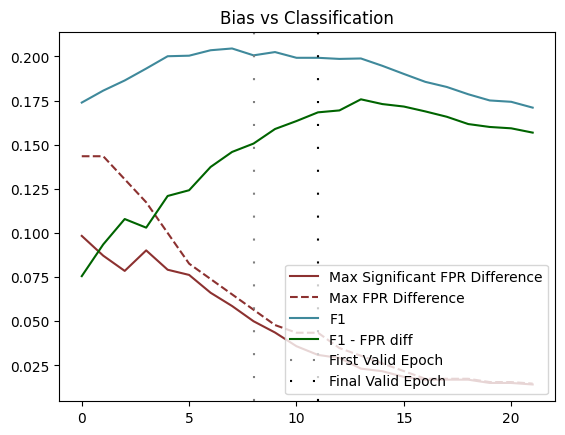

In [93]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
epochs = range(len(d["parity_hist"]["max_diff"]))

f1 = 2 * np.multiply(d["history_val"]["val_precision"], d["history_val"]["val_recall"]) / np.add(d["history_val"]["val_precision"], d["history_val"]["val_recall"])

first_valid_epoch = [x <= .05 for x in d["parity_hist"]["sig_diff"]].index(True)
last_valid_epoch = len(d["parity_hist"]["is_valid"]) - 1 - d["parity_hist"]["is_valid"][::-1].index(True)

plt.plot(epochs, d["parity_hist"]["sig_diff"], label="Max Significant FPR Difference", color = red)
plt.plot(epochs, d["parity_hist"]["max_diff"], label="Max FPR Difference", color = red, linestyle = "--")
plt.plot(epochs, f1, label="F1", color = blue)
plt.plot(
        epochs,
        np.subtract(f1,d["parity_hist"]["sig_diff"]),
        label="F1 - FPR diff", color = "darkgreen"
    )
plt.axvline(
    first_valid_epoch,
    color = "grey",
    linestyle = (0, (1,10)),
    label = "First Valid Epoch"
)
plt.axvline(
    last_valid_epoch,
    color = "black",
    linestyle = (0, (1,10)),
    label = "Final Valid Epoch"
)
plt.title("Bias vs Classification")
plt.legend(loc="lower right")
plt.show()

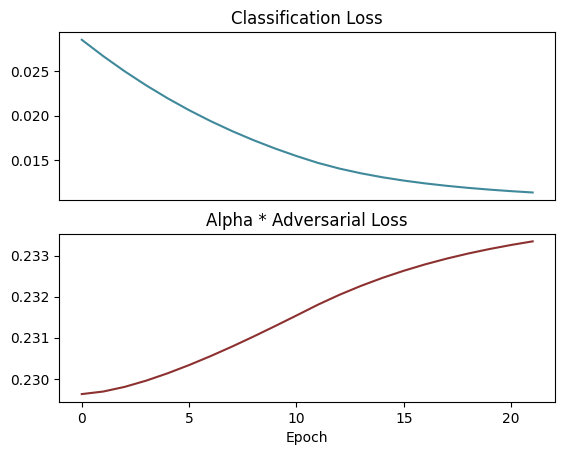

In [94]:
fig, axes = plt.subplots(nrows=2,ncols=1)

axes[0].plot(epochs, d["clf_loss"], label = "Predictor Loss", color = blue)
axes[0].set_title("Classification Loss")
axes[0].set_xticks([])
axes[1].set_title("Alpha * Adversarial Loss")
axes[1].plot(epochs, np.multiply(d["adv_loss"], .15), label = "Adversary Loss", color = red)
plt.xlabel("Epoch")
fig.subplots_adjust(wspace=0)
plt.show()

In [95]:
model_clf.set_weights(d["weights"][9])

In [96]:
get_performance_metrics_by_hist(d["history_val"], epoch = 9)

tn: 182715.0	fp:2336.0
fn: 1555.0	tp: 494.0
recall: 0.2410932183265686	precision: 0.17455829679965973	auc: 0.8679805994033813


In [228]:
pretrained_model = tf.keras.models.load_model('pretrained_clf.mdl')

In [97]:
from sklearn.metrics import roc_curve, roc_auc_score

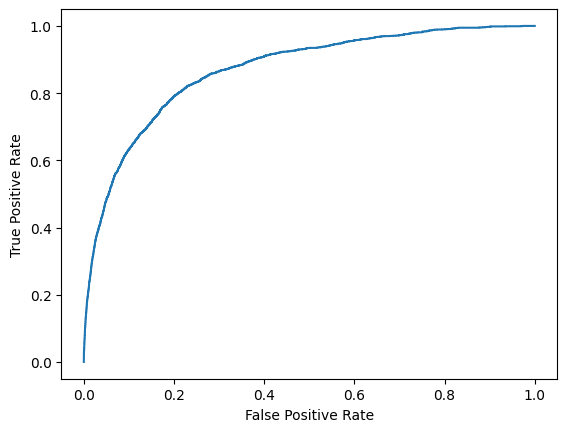

0.8686659261060448


In [98]:
#define metrics
y_pred_proba = model_clf(X_valid_transformed.values).numpy()
fpr, tpr, _ = roc_curve(y_valid_transformed,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Print area
print(roc_auc_score(y_valid_transformed, y_pred_proba))

## Train on training + valid data

Now using the hyperparameters found through gridsearch and picked by performance on our validation set, we repeat the process on the training + validation set and get final results on our test set

In [99]:
X_final = pd.concat(objs = [X_train_transformed, X_valid_transformed])
y_final = pd.concat(objs = [y_train_transformed, y_valid_transformed])

In [100]:
pos = sum(y_final)
neg = len(y_final) - pos
init_bias = np.log(pos / neg)

In [101]:
final_model, history = pretrain_classifier(
    "Final",
    {0: 0.505, 1:11.17},
    init_bias,
    [Dense(13, activation='relu')],
    .001,
    X_final.values,
    y_final.values,
    X_test_transformed,
    y_test_transformed
)

Epoch 1/200
2928/2928 [==============================] - 6s 2ms/step - loss: 0.2184 - tp: 3667.0000 - fp: 34119.0000 - tn: 707002.0000 - fn: 4615.0000 - accuracy: 0.9483 - precision: 0.0970 - recall: 0.4428 - auc: 0.8527 - prc: 0.1165 - val_loss: 0.2097 - val_tp: 1587.0000 - val_fp: 17760.0000 - val_tn: 228967.0000 - val_fn: 1149.0000 - val_accuracy: 0.9242 - val_precision: 0.0820 - val_recall: 0.5800 - val_auc: 0.8782 - val_prc: 0.1399 - lr: 0.0010
Epoch 2/200
2928/2928 [==============================] - 4s 1ms/step - loss: 0.2075 - tp: 4114.0000 - fp: 38793.0000 - tn: 702328.0000 - fn: 4168.0000 - accuracy: 0.9427 - precision: 0.0959 - recall: 0.4967 - auc: 0.8716 - prc: 0.1286 - val_loss: 0.1682 - val_tp: 1369.0000 - val_fp: 11849.0000 - val_tn: 234878.0000 - val_fn: 1367.0000 - val_accuracy: 0.9470 - val_precision: 0.1036 - val_recall: 0.5004 - val_auc: 0.8799 - val_prc: 0.1435 - lr: 0.0010
Epoch 3/200
2928/2928 [==============================] - 4s 1ms/step - loss: 0.2059 - tp: 41

In [102]:
final_model.save("final_pretrained.mdl")

INFO:tensorflow:Assets written to: final_pretrained.mdl\assets


INFO:tensorflow:Assets written to: final_pretrained.mdl\assets


In [184]:
final_model = tf.keras.models.load_model('final_pretrained.mdl')

In [185]:
y_pred = final_model(X_test_transformed.values)
y_labels = y_pred > .5
y_true = y_test_transformed

In [186]:
X_final_preds = X_test_transformed.copy()

In [187]:
X_final_preds["preds"] = y_pred.numpy()

In [188]:
X_final_preds["labels"] = X_final_preds["preds"] > 0.5

In [189]:
X_final_preds["correct"] = X_final_preds["labels"] == y_test_transformed.values

In [190]:
def false_neg_cond(df):
    return (df["labels"] == False) and (df["correct"] == False)
def false_pos_cond(df):
    return (df["labels"] == True) and (df["correct"] == False)
def true_neg_cond(df):
    return (df["labels"] == False) and (df["correct"] == True)
def true_pos_cond(df):
    return (df["labels"] == True) and (df["correct"] == True)

In [191]:
X_final_preds["fp"] = X_final_preds.apply(false_pos_cond, axis = 1)
X_final_preds["fn"] = X_final_preds.apply(false_neg_cond, axis = 1)
X_final_preds["tp"] = X_final_preds.apply(true_pos_cond, axis = 1)
X_final_preds["tn"] = X_final_preds.apply(true_neg_cond, axis = 1)

In [192]:
fp = sum(X_final_preds['fp'])
tn = sum(X_final_preds['tn'])
fn = sum(X_final_preds['fn'])
tp = sum(X_final_preds['tp'])
fpr = fp / (fp + tn)
mcc = ((tp*tn) - (fp * fn)) / np.sqrt((tp+fp)*(fp+fn)*(tn+fp)*(tn+fn))
fpr_test = fpr
print(f"Full Test Set, fpr: {fpr}")
print(f"tn: {tn}\tfp: {fp}")
print(f"fn: {fn}\ttp: {tp}")
print("\n")
ages = list()
fps = list()
tns = list()
fns = list()
tps = list()
fprs = list()
for val in sorted(X_final["customer_age"].unique()):
    sub = X_final_preds[X_final_preds["customer_age"] == val]
    fp = sum(sub['fp'])
    tn = sum(sub['tn'])
    fn = sum(sub['fn'])
    tp = sum(sub['tp'])
    fpr = fp / (fp + tn)
    print(f"val: {val}, fpr: {fpr}")
    print(f"tn: {tn}\tfp: {fp}")
    print(f"fn: {fn}\ttp: {tp}")
    print("\n")
    ages.append(val)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    tps.append(tp)
    fprs.append(fpr)
print("mcc",mcc)

Full Test Set, fpr: 0.05284788450392539
tn: 233688	fp: 13039
fn: 1240	tp: 1496


val: 0.0, fpr: 0.008331718659174578
tn: 5118	fp: 43
fn: 18	tp: 5


val: 0.125, fpr: 0.013777267508610792
tn: 60130	fp: 840
fn: 203	tp: 83


val: 0.25, fpr: 0.030510625623227445
tn: 74863	fp: 2356
fn: 360	tp: 249


val: 0.375, fpr: 0.0734457520335558
tn: 54562	fp: 4325
fn: 308	tp: 461


val: 0.5, fpr: 0.11313207987854723
tn: 30377	fp: 3875
fn: 236	tp: 432


val: 0.625, fpr: 0.1483065953654189
tn: 7167	fp: 1248
fn: 91	tp: 210


val: 0.75, fpr: 0.18762343647136273
tn: 1234	fp: 285
fn: 22	tp: 46


val: 0.875, fpr: 0.21107266435986158
tn: 228	fp: 61
fn: 2	tp: 8


val: 1.0, fpr: 0.4
tn: 9	fp: 6
fn: 0	tp: 2


mcc 0.09613268655287048


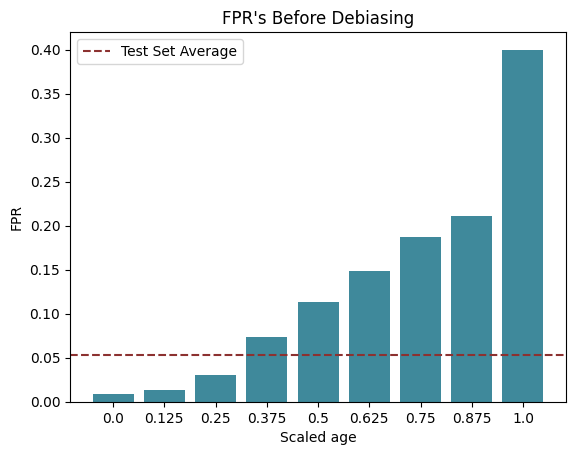

In [193]:
plt.bar([str(a) for a in ages], fprs, color = blue)
plt.axhline(fpr_test, linestyle = "--", color = red, label = "Test Set Average")
plt.title("FPR's Before Debiasing")
plt.xlabel("Scaled age")
plt.ylabel("FPR")
plt.legend()
plt.show()

In [194]:
p_pre = get_fpr_parity(
    get_disparity_df_tf(
        model=final_model,
        do_print=False,
        X_val = X_test_transformed.values,
        y_val = y_test_transformed,
        X_id_mat=X_test))

In [195]:
print("Max Diff:", max(fprs) - min(fprs))

Max Diff: 0.39166828134082543


In [196]:
final_adv = Sequential()
final_adv.add(Dense(15, input_dim=1, activation='relu'))
#model_adv.add(Dense(25, activation='relu'))
final_adv.add(Dense(9, activation='softmax'))

# optimizer
opt_adv = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the keras model
final_adv.compile(loss='categorical_crossentropy', optimizer=opt_adv)

# Get income targets
incomes = np.unique(X_final["customer_age"])
y_income = pd.DataFrame()
y_income["target"] = X_final["customer_age"].copy()
for val in incomes:
    y_income[f"age_{val}"] = (y_income["target"] == val).astype(int)
cols = y_income.columns.tolist()
cols.remove("target")

y_adv = y_income[cols].values

print("Getting clf predictions")
X_adv = final_model(X_final.values)

reduce_lr_adv = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1
    )


early_stopping_adv = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True
    )

history_adv = final_adv.fit(
    X_adv,
    y_adv,
    epochs=n_pretrain_epochs,
    batch_size=256,
    callbacks=[early_stopping_adv, reduce_lr_adv]
    )

Getting clf predictions
Epoch 1/30
2928/2928 [==============================] - 3s 768us/step - loss: 1.5309 - lr: 0.0100
Epoch 2/30
2928/2928 [==============================] - 2s 735us/step - loss: 1.5209 - lr: 0.0100
Epoch 3/30
2928/2928 [==============================] - 2s 732us/step - loss: 1.5205 - lr: 0.0100
Epoch 4/30
2928/2928 [==============================] - 2s 733us/step - loss: 1.5203 - lr: 0.0100
Epoch 5/30
2928/2928 [==============================] - 2s 742us/step - loss: 1.5202 - lr: 0.0100
Epoch 6/30
2928/2928 [==============================] - 2s 731us/step - loss: 1.5202 - lr: 0.0100
Epoch 7/30
2928/2928 [==============================] - 2s 751us/step - loss: 1.5201 - lr: 0.0100
Epoch 8/30
2928/2928 [==============================] - 2s 765us/step - loss: 1.5199 - lr: 0.0100
Epoch 9/30
2928/2928 [==============================] - 2s 738us/step - loss: 1.5198 - lr: 0.0100
Epoch 10/30
2928/2928 [==============================] - 2s 745us/step - loss: 1.5197 - lr: 0.

In [197]:
final_adv.save("final_pretrained_adv.mdl")

INFO:tensorflow:Assets written to: final_pretrained_adv.mdl\assets


INFO:tensorflow:Assets written to: final_pretrained_adv.mdl\assets


In [198]:
def create_weighted_binary_crossentropy(class_weights):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        bce = keras.losses.BinaryCrossentropy()
        b_ce = bce(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return tf.math.reduce_mean(weighted_b_ce)
    return weighted_binary_crossentropy
    
def debias2(alpha, lr_clf, lr_adv, decay, decay_step, X_clf, y_clf, X_clf_val, y_clf_val, y_adv, metrics, class_weights):
    # Store params
    params = {
        "a": alpha,
        "lr_clf": lr_clf,
        "lr_adv": lr_adv,
        "decay": decay,
        "decay_step" : decay_step,
        "class_weights" : class_weights
    }
    # Where to track metrics
    change_thresh = .00001
    invalid_epochs = 0
    history = dict([(m.name, list()) for m in metrics])
    history_valid = dict([(f"val_{m.name}", list()) for m in metrics])
    parity_hist = {
        "avg_z" : list(),
        "max_z" : list(),
        "n_groups" : list(),
        "max_diff" : list(),
        "sig_diff" : list(),
        "is_valid" : list()
    }
    best_z = 50
    best_n_groups = 0
    best_z_avg = 50
    best_weights = {
        "Best Z max" : list(),
        "Best Z avg" : list(),
        "Best n groups" : list()
    }
    ws = list()
    clf_losses = list()
    adv_losses = list()
    last_clf_loss = 0
    last_adv_loss = 0
    last_max_z = 0
    no_change_count = 0
    # Load in clean models
    model_adv = tf.keras.models.load_model('final_pretrained_adv.mdl')
    model_clf = tf.keras.models.load_model('final_pretrained.mdl')
    optimizer_clf = tf.keras.optimizers.Adam(learning_rate=lr_clf)
    optimizer_adv = tf.keras.optimizers.Adam(learning_rate=lr_adv)
    # Iterate over the batches of a dataset.
    bce = keras.losses.BinaryCrossentropy()
    cce = keras.losses.CategoricalCrossentropy()
    clf_loss = create_weighted_binary_crossentropy(class_weights)
    # Train Loop
    for epoch in range(100):
        with tf.GradientTape() as predictor_tape, tf.GradientTape() as adversary_tape, tf.GradientTape() as adv_tape2:
            # Forward pass through the predictor network
            y_pred = model_clf(X_clf)
            
            # Forward pass through the adversary network
            z_pred = model_adv(y_pred)
            
            # Calculate the losses
            predictor_loss = clf_loss(y_clf, y_pred)
            adversary_loss = cce(y_adv, z_pred)
            
        # Calculate the gradients separately for the predictor and adversary
        predictor_gradients = predictor_tape.gradient(predictor_loss, model_clf.trainable_variables)
        adversary_gradients = adversary_tape.gradient(adversary_loss, model_adv.trainable_variables)

        # Calculate the gradients for LA with respect to model_clf.trainable_variables
        adversary_gradients_wrt_weights = adv_tape2.gradient(adversary_loss, model_clf.trainable_variables)
        
        # Calculate the projection term
        #proj = [tf.math.multiply(projection(u, v), alpha) for u, v in zip(predictor_gradients, adversary_gradients_wrt_weights)]
        proj = [projection(u, v) for u, v in zip(predictor_gradients, adversary_gradients_wrt_weights)]

        # Get final gradients for classifier update
        # # For loops are for each mini-batch
        updated_gradient = list()
        # First get delta W - projection of delta W on Clf Loss to delta W of Adv Loss, per Zhang et al
        for x, y in zip(predictor_gradients, proj):
            updated_gradient.append(tf.math.subtract(x, y))
        
        # Then get alpha * Loss Adv
        decayed_grads = list()
        for g in adversary_gradients_wrt_weights:
            decayed_grads.append(tf.math.multiply(alpha, g))
        
        for i, grad in enumerate(updated_gradient):
            updated_gradient[i] = tf.math.subtract(grad, decayed_grads[i])
        
        # Update the weights of the predictor network
        optimizer_clf.apply_gradients(zip(updated_gradient, model_clf.trainable_variables))
        lr_clf = lr_clf * 1/(1 + decay * (epoch // decay_step))
        optimizer_clf.learning_rate.assign(lr_clf)

        # Update the weights of the adversary network
        optimizer_adv.apply_gradients(zip(adversary_gradients, model_adv.trainable_variables))
        lr_adv = lr_adv * 1/(1 + decay * (epoch // decay_step))
        optimizer_adv.learning_rate.assign(lr_adv)

        # Store Metrics       
        for m in metrics:
            m.reset_states()
            m.update_state(y_clf,model_clf(X_clf)) # Calculate training metric
            history[m.name].append(m.result().numpy())
            m.reset_states()
            m.update_state(y_clf_val,model_clf(X_clf_val)) # Calculate validation metric
            history_valid[f"val_{m.name}"].append(m.result().numpy())

        # Get parity stats
        par_df = get_parity_df(
            dd := get_disparity_df_tf(
                model_clf,
                X_val = X_test_transformed.values,
                y_val = y_test_transformed,
                X_id_mat = X_test,
                do_print=False)
            ,groups=["age"])
        n_par_groups = sum(par_df["has parity"])
        max_z = max(abs(par_df["parity score"]))
        avg_z = np.mean(abs(par_df["parity score"]))
        max_diff = max(par_df["value"]) - min(par_df["value"])
        sig_diff = get_significant_max_diff(dd)

        parity_hist["avg_z"].append(avg_z)
        parity_hist["max_z"].append(max_z)
        parity_hist["n_groups"].append(n_par_groups)
        parity_hist["max_diff"].append(max_diff)
        parity_hist["sig_diff"].append(sig_diff)
        clf_losses.append(predictor_loss)
        adv_losses.append(adversary_loss)

        ws.append(model_clf.get_weights().copy())
        # If valid classifier, check parity performance
        if get_classifier_validity_2(history_valid, -1, min_recall=.2, min_precision=.0175):
            invalid_epochs = 0
            parity_hist["is_valid"].append(True)
        else: 
            invalid_epochs += 1
            parity_hist["is_valid"].append(False)
        
        if all([(abs(curr - prev) < change_thresh) for curr, prev in zip([predictor_loss, adversary_loss], [last_clf_loss, last_adv_loss])]):
            no_change_count += 1
            print(f"No Change: {no_change_count}")
        else: no_change_count = 0
        # Break loop ifs
        if invalid_epochs >= 10:
            print("10 invalid classification checks. Breaking")
            break
        if no_change_count >= 5:
            print("No change in 5 epochs. Breaking")
            break
        # Update vals
        last_clf_loss = predictor_loss
        last_adv_loss = adversary_loss
        last_max_z = max_z
        # Print metrics
        print(f"{epoch} / 500\tclf loss: {predictor_loss}\tadv loss: {adversary_loss}\tsig_diff: {sig_diff}")
        print(f"tn:{history['tn'][-1]}\tfp:{history['fp'][-1]}\ttp:{history['tp'][-1]}\tfn:{history['fn'][-1]}\t")
        print(f"vtn:{history_valid['val_tn'][-1]}\tvfp:{history_valid['val_fp'][-1]}\tvtp:{history_valid['val_tp'][-1]}\tvfn:{history_valid['val_fn'][-1]}\t")
        
    return params, parity_hist, history, history_valid , model_clf, model_adv, ws, clf_losses, adv_losses

In [199]:
d_final = dict(
    [(x,y) for x,y in zip(
        out_names,
        debias2(
            alpha=.15,
            lr_clf=.001,
            lr_adv=.001,
            decay=.1,
            decay_step=10,
            X_clf=X_final.values,
            y_clf=y_final.values.reshape(-1,1),
            X_clf_val=X_test_transformed.values,
            y_clf_val=y_test_transformed.values.reshape(-1,1),
            y_adv=y_adv,
            metrics=METRICS,
            class_weights={0:0.505, 1:11.17}
            )
        )
    ]
)
d_final

0 / 500	clf loss: 0.10412242263555527	adv loss: 1.5187716484069824	sig_diff: 0.12239246241320621
tn:707826.0	fp:33295.0	tp:4245.0	fn:4037.0	
vtn:235628.0	vfp:11099.0	vtp:1420.0	vfn:1316.0	
1 / 500	clf loss: 0.09461469948291779	adv loss: 1.5196465253829956	sig_diff: 0.13677350983645892
tn:712832.0	fp:28289.0	tp:3962.0	fn:4320.0	
vtn:237357.0	vfp:9370.0	vtp:1341.0	vfn:1395.0	
2 / 500	clf loss: 0.08610299229621887	adv loss: 1.5206937789916992	sig_diff: 0.11950289550726004
tn:717103.0	fp:24018.0	tp:3672.0	fn:4610.0	
vtn:238755.0	vfp:7972.0	vtp:1229.0	vfn:1507.0	
3 / 500	clf loss: 0.07870917022228241	adv loss: 1.5219024419784546	sig_diff: 0.10684057610893674
tn:720728.0	fp:20393.0	tp:3389.0	fn:4893.0	
vtn:239914.0	vfp:6813.0	vtp:1147.0	vfn:1589.0	
4 / 500	clf loss: 0.07236092537641525	adv loss: 1.5231693983078003	sig_diff: 0.09746989594695314
tn:723705.0	fp:17416.0	tp:3135.0	fn:5147.0	
vtn:240830.0	vfp:5897.0	vtp:1066.0	vfn:1670.0	
5 / 500	clf loss: 0.06694542616605759	adv loss: 1.524423956

{'params': {'a': 0.15,
  'lr_clf': 0.001,
  'lr_adv': 0.001,
  'decay': 0.1,
  'decay_step': 10,
  'class_weights': {0: 0.505, 1: 11.17}},
 'parity_hist': {'avg_z': [23.579826477411203,
   22.42891747867032,
   21.402171781821178,
   20.388123161790936,
   19.27827942976483,
   18.23505678685227,
   17.673256285894606,
   16.45745605205651,
   15.92710636303093,
   15.240098385337989,
   14.247452641945127,
   13.672993467629766,
   13.221634743427792,
   13.078747051937698,
   12.829784442504026,
   12.546283153213398,
   12.221041675549907,
   11.740385185305342,
   11.432257189774113,
   11.340932318936533,
   11.109954266095365,
   10.988482442554703,
   10.941344799607197,
   10.836901883035331],
  'max_z': [41.25970641629503,
   39.552893962443676,
   37.61745580736169,
   35.3947995567763,
   33.70666125372755,
   31.72949798775724,
   29.837326436484766,
   28.35121569768859,
   27.294369537923558,
   25.739654633264255,
   24.685431039998683,
   24.226005526035276,
   23.35280

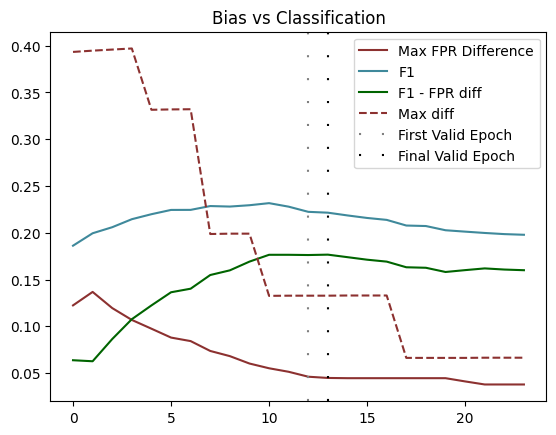

In [200]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
epochs = range(len(d_final["parity_hist"]["max_diff"]))

f1 = 2 * np.multiply(d_final["history_val"]["val_precision"], d_final["history_val"]["val_recall"]) / np.add(d_final["history_val"]["val_precision"], d_final["history_val"]["val_recall"])

first_valid_epoch = [x <= .05 for x in d_final["parity_hist"]["sig_diff"]].index(True)
last_valid_epoch = len(d_final["parity_hist"]["is_valid"]) - 1 - d_final["parity_hist"]["is_valid"][::-1].index(True)

plt.plot(epochs, d_final["parity_hist"]["sig_diff"], label="Max FPR Difference", color = red)
plt.plot(epochs, f1, label="F1", color = blue)
plt.plot(
        epochs,
        np.subtract(f1,d_final["parity_hist"]["sig_diff"]),
        label="F1 - FPR diff", color = "darkgreen"
    )
plt.plot(
        epochs,
        d_final["parity_hist"]["max_diff"],
        label="Max diff", color = red, linestyle = "--"
    )
plt.axvline(
    first_valid_epoch,
    color = "grey",
    linestyle = (0, (1,10)),
    label = "First Valid Epoch"
)
plt.axvline(
    last_valid_epoch,
    color = "black",
    linestyle = (0, (1,10)),
    label = "Final Valid Epoch"
)
plt.title("Bias vs Classification")
plt.legend(loc = "upper right")
plt.show()

In [201]:
np.subtract(f1[12:14],d_final["parity_hist"]["max_diff"][12:14]) # 33

array([0.08959557, 0.08868907])

In [202]:
get_min_samples(.04, err = .01)

1475.1744

In [203]:
p = get_fpr_parity(
    get_disparity_df_tf(
        model=final_model,
        do_print=False,
        X_val = X_test_transformed.values,
        y_val = y_test_transformed,
        X_id_mat=X_test))
p["age"]["pval"] > .01

,10,20,30,40,50,60,70,80,90
10,True,False,False,False,False,False,False,False,False
20,False,True,False,False,False,False,False,False,False
30,False,False,True,False,False,False,False,False,False
40,False,False,False,True,False,False,False,False,False
50,False,False,False,False,True,False,False,False,False
60,False,False,False,False,False,True,False,False,False
70,False,False,False,False,False,False,True,True,True
80,False,False,False,False,False,False,True,True,True
90,False,False,False,False,False,False,True,True,True


In [204]:
p["age"]["pval"] - p_pre["age"]["pval"]

,10,20,30,40,50,60,70,80,90
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
best_weights = d_final["weights"][12]
final_model.set_weights(best_weights)

In [206]:
y_pred = final_model(X_test_transformed.values)
y_labels = y_pred > .5
y_true = y_test_transformed

In [207]:
X_final_preds = X_test_transformed.copy()

In [208]:
X_final_preds["preds"] = y_pred.numpy()
X_final_preds["labels"] = X_final_preds["preds"] > 0.5
X_final_preds["correct"] = X_final_preds["labels"] == y_test_transformed.values

In [209]:
X_final_preds["fp"] = X_final_preds.apply(false_pos_cond, axis = 1)
X_final_preds["fn"] = X_final_preds.apply(false_neg_cond, axis = 1)
X_final_preds["tp"] = X_final_preds.apply(true_pos_cond, axis = 1)
X_final_preds["tn"] = X_final_preds.apply(true_neg_cond, axis = 1)

In [210]:
fp = sum(X_final_preds['fp'])
tn = sum(X_final_preds['tn'])
fn = sum(X_final_preds['fn'])
tp = sum(X_final_preds['tp'])
fpr = fp / (fp + tn)
mcc = ((tp*tn) - (fp * fn)) / np.sqrt((tp+fp)*(fp+fn)*(tn+fp)*(tn+fn))
fpr_test = fpr
print(f"Full Test Set, fpr: {fpr}")
print(f"tn: {tn}\tfp: {fp}")
print(f"fn: {fn}\ttp: {tp}")
print("\n")
ages = list()
fps = list()
tns = list()
fns = list()
tps = list()
fprs = list()
for val in sorted(X_final["customer_age"].unique()):
    sub = X_final_preds[X_final_preds["customer_age"] == val]
    fp = sum(sub['fp'])
    tn = sum(sub['tn'])
    fn = sum(sub['fn'])
    tp = sum(sub['tp'])
    fpr = fp / (fp + tn)
    print(f"val: {val}, fpr: {fpr}")
    print(f"tn: {tn}\tfp: {fp}")
    print(f"fn: {fn}\ttp: {tp}")
    print("\n")
    ages.append(val)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    tps.append(tp)
    fprs.append(fpr)
print("mcc",mcc)

Full Test Set, fpr: 0.00806154170398862
tn: 244738	fp: 1989
fn: 2145	tp: 591


val: 0.0, fpr: 0.0005812826971517147
tn: 5158	fp: 3
fn: 23	tp: 0


val: 0.125, fpr: 0.0009840905363293422
tn: 60910	fp: 60
fn: 268	tp: 18


val: 0.25, fpr: 0.0033411466089951956
tn: 76961	fp: 258
fn: 528	tp: 81


val: 0.375, fpr: 0.01012107935537555
tn: 58291	fp: 596
fn: 593	tp: 176


val: 0.5, fpr: 0.02084549807310522
tn: 33538	fp: 714
fn: 478	tp: 190


val: 0.625, fpr: 0.03232323232323232
tn: 8143	fp: 272
fn: 209	tp: 92


val: 0.75, fpr: 0.0467412771560237
tn: 1448	fp: 71
fn: 40	tp: 28


val: 0.875, fpr: 0.04498269896193772
tn: 276	fp: 13
fn: 5	tp: 5


val: 1.0, fpr: 0.13333333333333333
tn: 13	fp: 2
fn: 1	tp: 1


mcc 0.17415537792900218


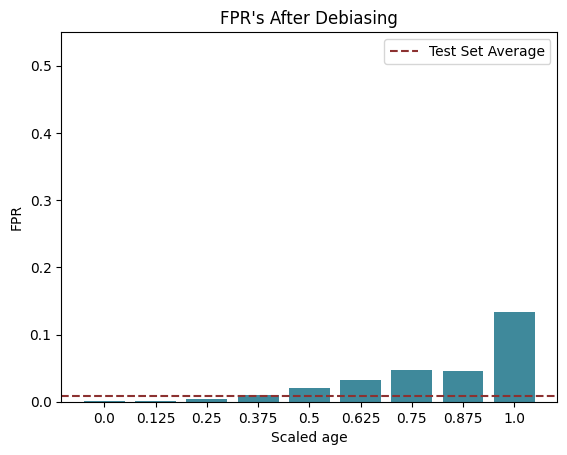

In [211]:
plt.bar([str(a) for a in ages], fprs, color = blue)
plt.axhline(fpr_test, linestyle = "--", color = red, label = "Test Set Average")
plt.title("FPR's After Debiasing")
plt.xlabel("Scaled age")
plt.ylabel("FPR")
plt.ylim((0,0.55))
plt.legend()
plt.show()

In [212]:
print(max(fprs) - min(fprs))

0.13275205063618162


## Final Evaluation

In [213]:
import shap

In [214]:
shap.initjs()

In [215]:
explainer = shap.KernelExplainer(final_model, shap.sample(X_final, 100))

In [216]:
sv1 = explainer.shap_values(X_test_transformed.iloc[:100,:])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


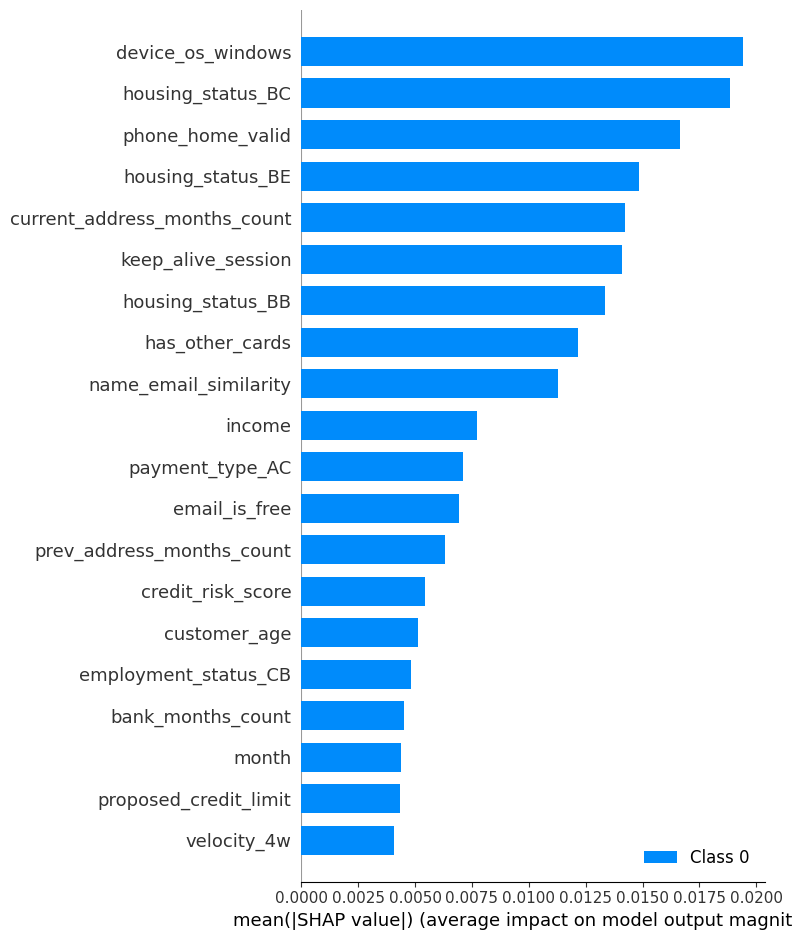

In [217]:
shap.summary_plot(sv1, X_test_transformed.iloc[:100,:])

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


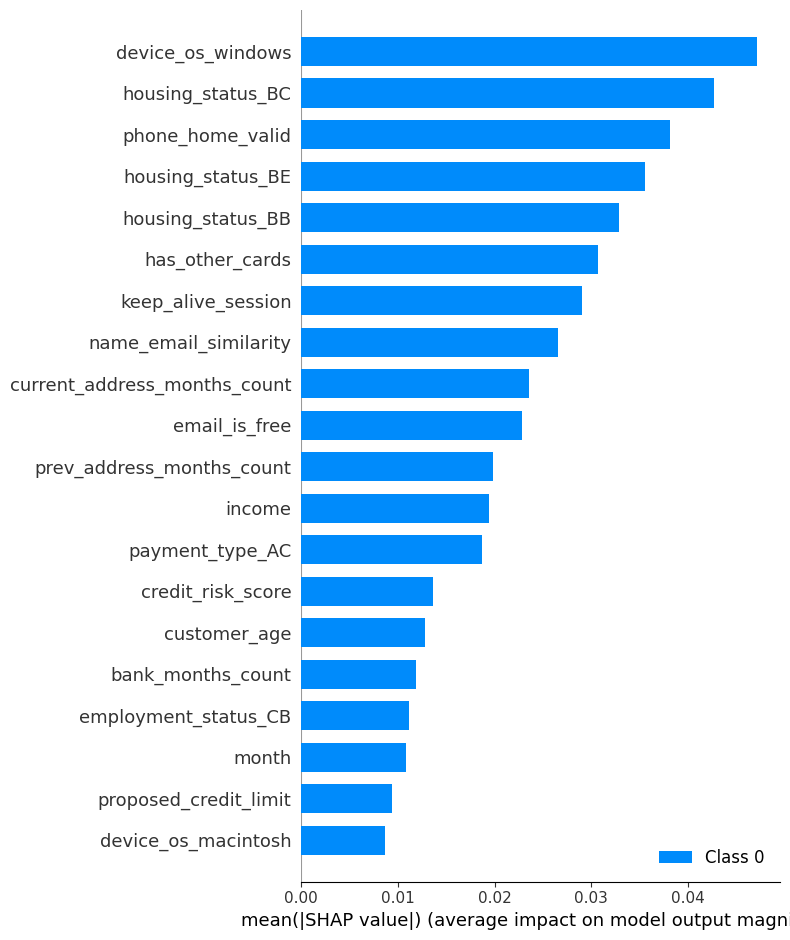

In [218]:
pretrained_model = tf.keras.models.load_model('final_pretrained.mdl')
explainer = shap.KernelExplainer(pretrained_model, shap.sample(X_final, 100))
sv = explainer.shap_values(X_test_transformed.iloc[:100,:])
shap.summary_plot(sv, X_test_transformed.iloc[:100,:])

In [219]:
sorted(df_master.corr()["customer_age"])

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


[-0.42017271032425574,
 -0.14709791809394385,
 -0.06917758650778719,
 -0.0489022393745018,
 -0.03599852707423658,
 -0.024271530279480043,
 -0.022062949139989744,
 -0.014175617891470666,
 -0.012999764651230589,
 -0.01003004410050399,
 -0.004302623032513105,
 -0.001606141680868214,
 -0.00035684653842243177,
 0.00569435923672248,
 0.012906871383488207,
 0.02504854361796228,
 0.02570871330392273,
 0.048412413353504616,
 0.06295865025001722,
 0.10874304076536866,
 0.12582230094762373,
 0.14286318059353423,
 0.14885705039691635,
 0.16609388774223827,
 0.21271311484016567,
 1.0,
 nan]

In [220]:
df_master.corr()["customer_age"]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


fraud_bool                          0.062959
income                              0.125822
name_email_similarity              -0.048902
prev_address_months_count          -0.069178
current_address_months_count        0.142863
customer_age                        1.000000
days_since_request                 -0.035999
intended_balcon_amount             -0.013000
zip_count_4w                       -0.014176
velocity_6h                        -0.022063
velocity_24h                       -0.010030
velocity_4w                        -0.004303
bank_branch_count_8w                0.048412
date_of_birth_distinct_emails_4w   -0.420173
credit_risk_score                   0.166094
email_is_free                      -0.000357
phone_home_valid                    0.212713
phone_mobile_valid                 -0.147098
bank_months_count                   0.012907
has_other_cards                     0.108743
proposed_credit_limit               0.148857
foreign_request                    -0.001606
session_le

In [221]:
test_preds = final_model(X_test_transformed.values)

Legitimate Transactions Detected (True Negatives):  244738
Legitimate Transactions Incorrectly Detected (False Positives):  1989
Fraudulent Transactions Missed (False Negatives):  2145
Fraudulent Transactions Detected (True Positives):  591
Total Fraudulent Transactions:  2736


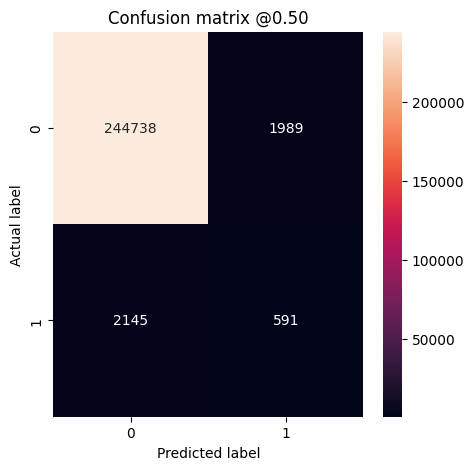

In [222]:
plot_cm(y_test_transformed,test_preds)

In [223]:
fps = list()
tns = list()
fprs = list()
for age in np.unique(X_test_transformed["customer_age"]):
    idx = X_test_transformed[X_test_transformed["customer_age"]==age].index
    df_temp = X_test_transformed.loc[idx]
    y_temp = y_test_transformed.loc[idx] == 1
    y_preds = final_model(df_temp.values)
    y_labels = y_preds > 0.5
    y_labels = [y[0] for y in y_labels.numpy()]
    fp = sum([(x!=y) and (x==False) for x,y in zip(y_temp, y_labels)])
    tn = sum([(x==y) and (x==False) for x,y in zip(y_temp, y_labels)])
    fpr = fp / (fp + tn)
    fprs.append(fpr)
    fps.append(fp)
    tns.append(tn)

In [224]:
a = .01

for fp, tn in zip(fps, tns):
    pval, Z, p1, p2 = get_fpr_fairness_1(sum(fps), sum(tns), fp, tn)
    print(pval > a, Z, p1, p2)

False 6.004423610942521 0.00806154170398862 0.0005812826971517147
False 19.240802897777133 0.00806154170398862 0.0009840905363293422
False 13.792998699224281 0.00806154170398862 0.0033411466089951956
False -4.903453287351144 0.00806154170398862 0.01012107935537555
False -22.71394756306414 0.00806154170398862 0.02084549807310522
False -23.35280517055411 0.00806154170398862 0.03232323232323232
False -16.56710270469054 0.00806154170398862 0.0467412771560237
False -6.9962870712323895 0.00806154170398862 0.04498269896193772
False -5.422891686013877 0.00806154170398862 0.13333333333333333


In [225]:
# H0: p1 - p2 = 0,  Proportions are the same
# H1: p1 - p2 != 0, Proportions are different

def compare_proportions(s1: pd.DataFrame, s2: pd.DataFrame, a: float = .05):
    n1 = len(s1.index) # Length of sample 1
    n2 = len(s2.index) # Length of sample 2
    p1 = sum(s1["false_pos"]) / n1 # FP proportion for sample 1
    p2 = sum(s2["false_pos"]) / n2 # FP proportion for sample 2
    p = (   # Proportion for combined samples
            (sum(s1["false_pos"]) + sum(s2["false_pos"]))
            /(n1 + n2)
        )
    Z = (
        ((p1 - p2) - 0)
        / np.sqrt(p * (1-p) * ((1/n1)+(1/n2)))
    )
    pval = 2*dist.norm.cdf(-np.abs(Z))
    return pval


In [226]:
pvals = np.zeros((len(disparity_dict["age"]),len(disparity_dict["age"])))
for r, row in enumerate(pvals):
    for c, col in enumerate(row):
        pvals[r][c] = (compare_proportions(disparity_dict['age'][r][-1], disparity_dict['age'][c][-1]))
pvals

NameError: name 'disparity_dict' is not defined

In [ ]:
def get_pval_array(disparity_dict):
    pvals = np.zeros((len(disparity_dict["age"]),len(disparity_dict["age"])))
    for r, row in enumerate(pvals):
        for c, col in enumerate(row):
            pvals[r][c] = (compare_proportions(disparity_dict['age'][r][-1], disparity_dict['age'][c][-1]))
    
    return pvals

def plot_pval_heatmap(disparity_dict):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,8))

    for i, cat in enumerate(disparity_dict):
        ax = axes[i]
        pvals = np.zeros((len(disparity_dict[cat]),len(disparity_dict[cat])))
        for r, row in enumerate(pvals):
            for c, col in enumerate(row):
                pvals[r][c] = (compare_proportions(disparity_dict[cat][r][-1], disparity_dict[cat][c][-1]))
        im = ax.imshow(pvals, cmap="Reds_r")
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

        # Show all ticks and label them with the respective list entries
        if cat != "income":
            ax.set_xticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
            ax.set_yticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
        else:
            ax.set_xticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
            ax.set_yticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), ha="center")

        # Loop over data dimensions and create text annotations.
        for i in range(len(pvals)):
            for j in range(len(pvals[0])):
                text = ax.text(j, i, '%.3f' % pvals[i, j],
                            ha="center", va="center", color="w")

        ax.set_title(f"Pvals for Proportion difference by {cat}")
        #fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([.15, .05, .6, 0.025])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    fig.suptitle("FPR Proportion Significance: P-Values by Category", size=20)
    plt.show()

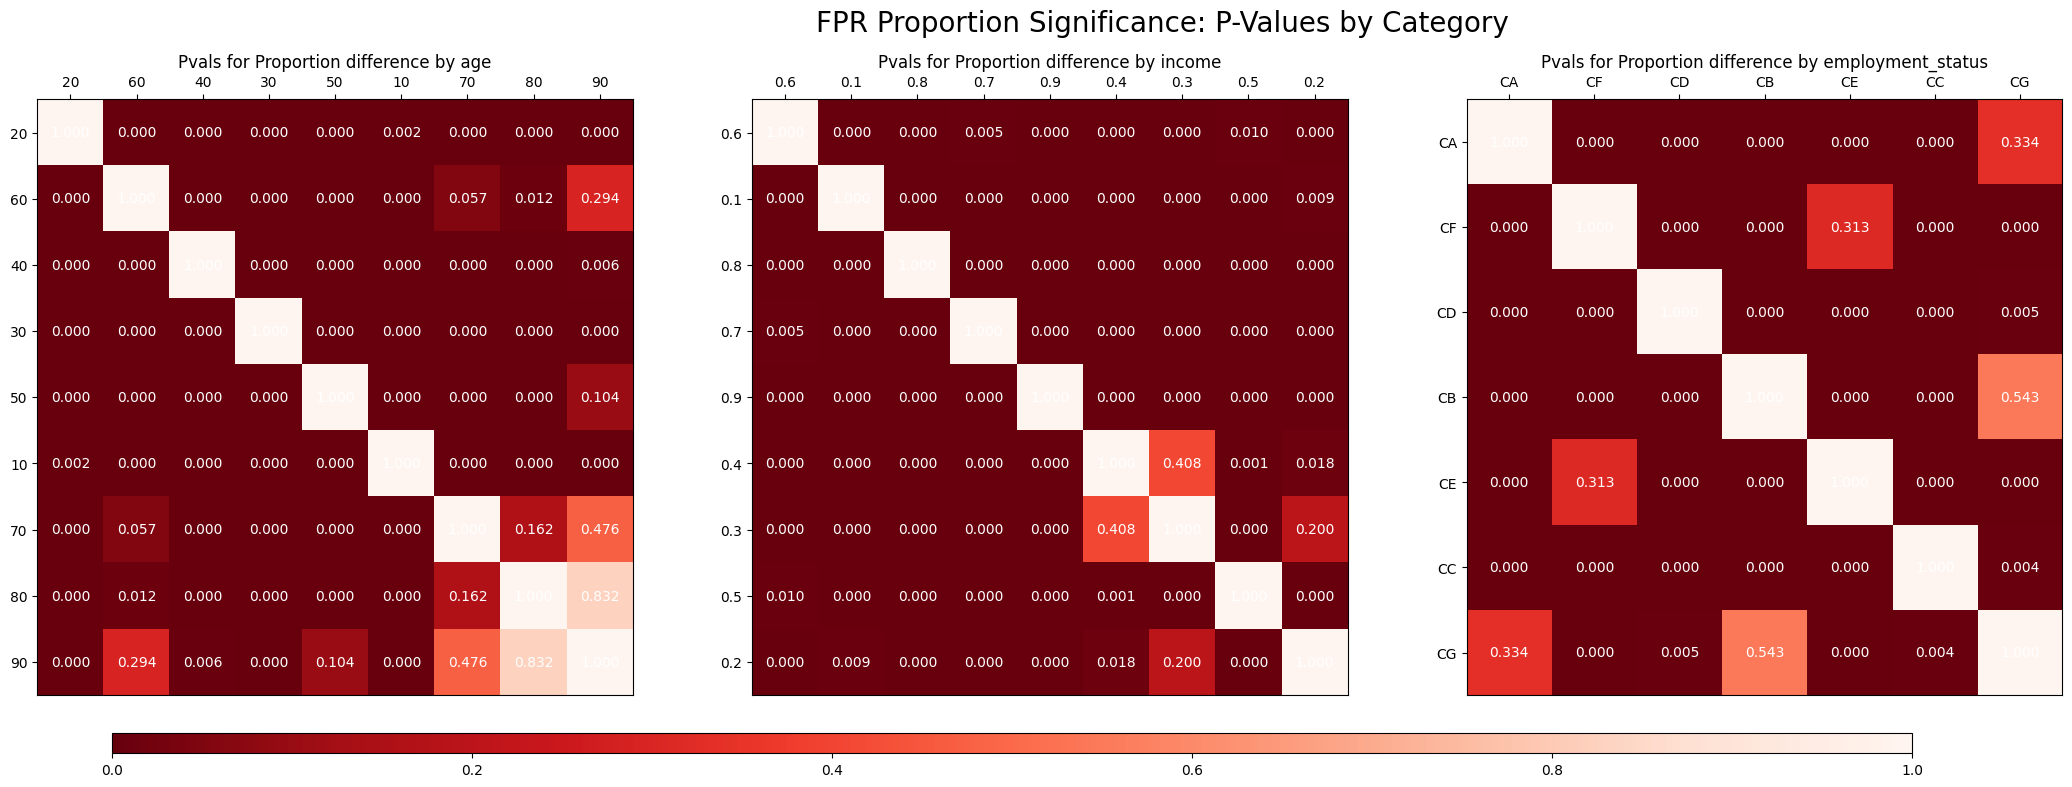

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,8))

for i, cat in enumerate(disparity_dict):
    ax = axes[i]
    pvals = np.zeros((len(disparity_dict[cat]),len(disparity_dict[cat])))
    for r, row in enumerate(pvals):
        for c, col in enumerate(row):
            pvals[r][c] = (compare_proportions(disparity_dict[cat][r][-1], disparity_dict[cat][c][-1]))
    im = ax.imshow(pvals, cmap="Reds_r")
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Show all ticks and label them with the respective list entries
    if cat != "income":
        ax.set_xticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
        ax.set_yticks(np.arange(len(pvals)), labels=[x[0] for x in disparity_dict[cat]])
    else:
        ax.set_xticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
        ax.set_yticks(np.arange(len(pvals)), labels=['%.1f' % x[0] for x in disparity_dict[cat]])
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center")

    # Loop over data dimensions and create text annotations.
    for i in range(len(pvals)):
        for j in range(len(pvals[0])):
            text = ax.text(j, i, '%.3f' % pvals[i, j],
                        ha="center", va="center", color="w")

    ax.set_title(f"Pvals for Proportion difference by {cat}")
    #fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.15, .05, .6, 0.025])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
fig.suptitle("FPR Proportion Significance: P-Values by Category", size=20)
plt.show()

## Try to fix bias!!

<BarContainer object of 45 artists>

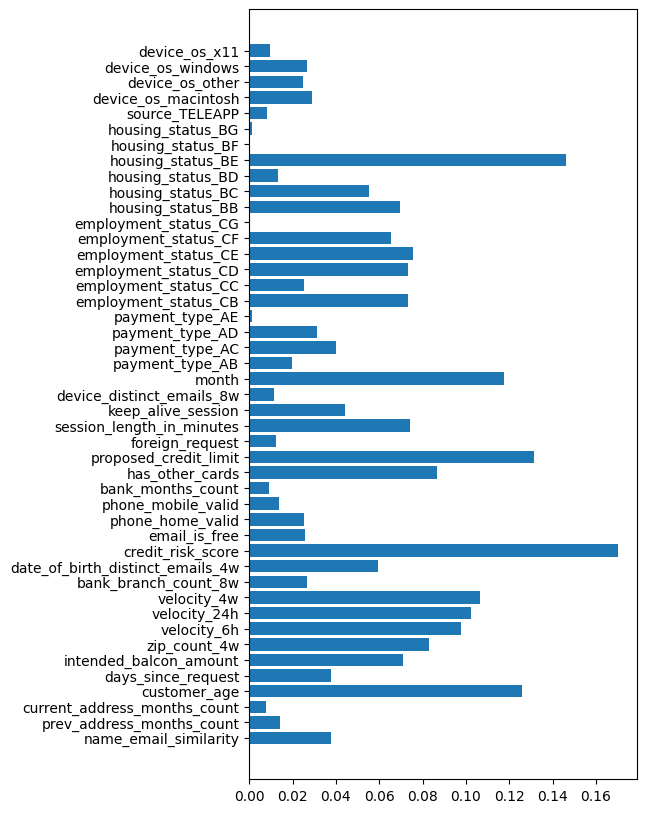

In [ ]:
# Get correlations
corr = X_train_transformed.corr()["income"]
corr = corr.drop("income")
plt.rcParams["figure.figsize"] = [5.0, 10.0]
plt.barh(corr.index,np.abs(corr.values))

<BarContainer object of 45 artists>

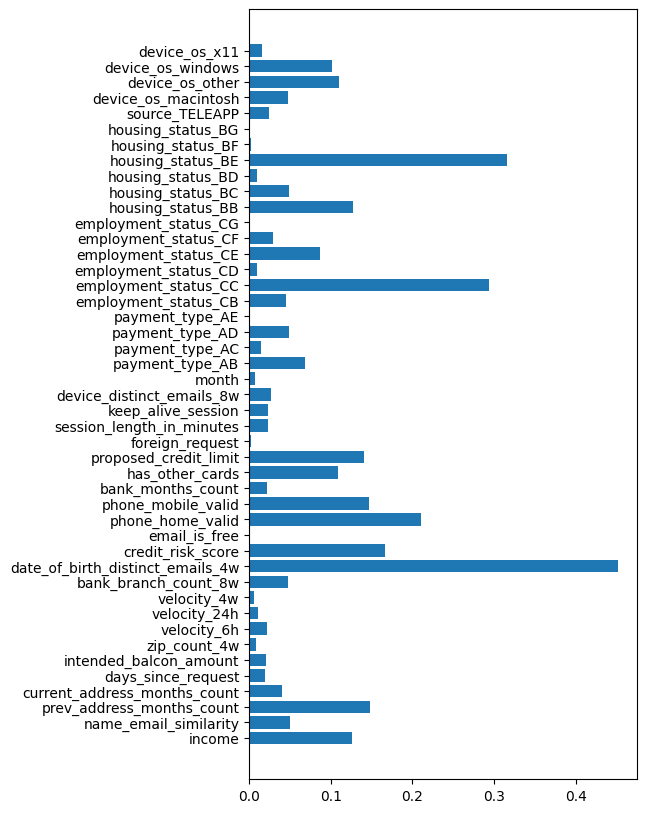

In [ ]:
# Get correlations
corr = X_train_transformed.corr()["customer_age"]
corr = corr.drop("customer_age")
plt.rcParams["figure.figsize"] = [5.0, 10.0]
plt.barh(corr.index,np.abs(corr.values))

In [ ]:
# Get correlations
corr = X_train_transformed.corr()[['employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',]]
#corr = corr.drop("employment_status")
#plt.rcParams["figure.figsize"] = [5.0, 10.0]
#plt.barh(corr.index,np.abs(corr.values))
corr

,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG
income,0.073308,-0.025070,-0.073121,-0.075376,-0.065468,0.000372
name_email_similarity,-0.042926,-0.031374,-0.008219,0.030863,-0.019869,-0.002627
prev_address_months_count,-0.074092,-0.048180,-0.007229,-0.022552,-0.005334,0.000475
current_address_months_count,0.015124,0.018507,-0.004926,0.002560,-0.003365,0.000410
customer_age,0.045011,0.293919,0.009764,-0.086432,0.029681,0.000456
days_since_request,-0.003533,0.011674,0.026950,0.003163,-0.011131,0.004317
intended_balcon_amount,0.032621,-0.031037,-0.032438,0.032427,-0.062038,0.001658
zip_count_4w,0.051041,0.000883,0.011992,0.002003,0.010646,-0.002087
velocity_6h,0.055442,0.011238,0.017359,0.011105,0.007981,0.000721
velocity_24h,0.071895,0.017198,0.016960,0.008154,-0.003549,0.000159


In [ ]:
X_train_transformed.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
       'employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',
       'housing_status_BB', 'housing_status_BC', 'housing_status_BD',
       'housing_status_BE', 'housing_status_BF', 'housing_status_BG',
       'source_TELEAP

In [ ]:
groups = ["income", "customer_age", "employment_status"]
cols = [x for x in X_train_transformed.columns if not any([y in x for y in groups])]
X_train_fair = X_train_transformed[cols]
X_valid_fair = X_valid_transformed[cols]

In [ ]:
ann2 = MLPClassifier(
    hidden_layer_sizes = (10),
    activation = 'tanh',
    solver = 'adam',
    learning_rate_init = .001,
    max_iter = 1000
    ).fit(X_train_fair, y_train_transformed)

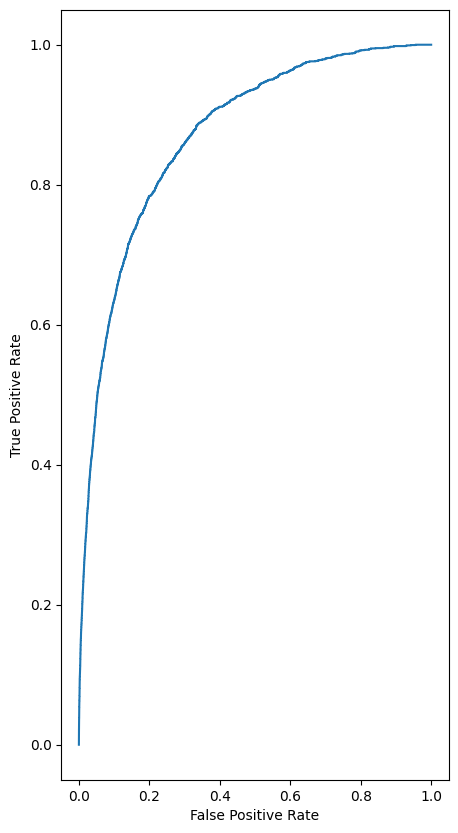

0.8703789298610232


In [ ]:
#define metrics
y_pred_proba = ann2.predict_proba(X_valid_fair)[::,1]
fpr, tpr, _ = roc_curve(y_valid_transformed,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Print area
print(roc_auc_score(y_valid_transformed, ann2.predict_proba(X_valid_fair)[:, 1]))

In [ ]:
ddf = get_disparity_df(ann2, X_valid_fair)
ddf

TPR:  48.86% 
FPR:  5.0% 
Prob Threshold:  0.05


,true_label,pred_prob,pred_label,true_pos,true_neg,false_pos,false_neg,age,income,employment_status
751477,0,0.000972,False,False,True,False,False,20,0.6,CA
974413,0,0.004391,False,False,True,False,False,60,0.1,CA
182186,0,0.001326,False,False,True,False,False,40,0.8,CA
595545,0,0.015924,False,False,True,False,False,30,0.8,CA
939928,0,0.000208,False,False,True,False,False,40,0.7,CA
...,...,...,...,...,...,...,...,...,...,...
603793,0,0.004414,False,False,True,False,False,30,0.8,CA
823365,0,0.005319,False,False,True,False,False,30,0.6,CA
899612,0,0.000663,False,False,True,False,False,20,0.6,CE
668928,0,0.006848,False,False,True,False,False,30,0.7,CB


In [ ]:
#Test for independence
ct = pd.crosstab(ddf["employment_status"], ddf["pred_label"])
stats.chi2_contingency(ct)

Chi2ContingencyResult(statistic=1037.745277411166, pvalue=6.126913265871676e-221, dof=6, expected_freq=array([[1.29209210e+05, 7.49579001e+03],
       [2.43787217e+04, 1.41427828e+03],
       [6.70596792e+03, 3.89032077e+02],
       [4.62187218e+03, 2.68127816e+02],
       [4.02074525e+03, 2.33254751e+02],
       [7.79952746e+03, 4.52472544e+02],
       [8.69554685e+01, 5.04453151e+00]]))

In [ ]:
ddct = get_disparity_dict(ddf)

age category is NOT fair!
            Max fpr: 0.12137823022709475
            Max value: 70
            Max n: 1277
            Min fpr: 0.01571759855707292
            Min value: 10
            Min n: 3881
            Difference: 0.10566063167002183





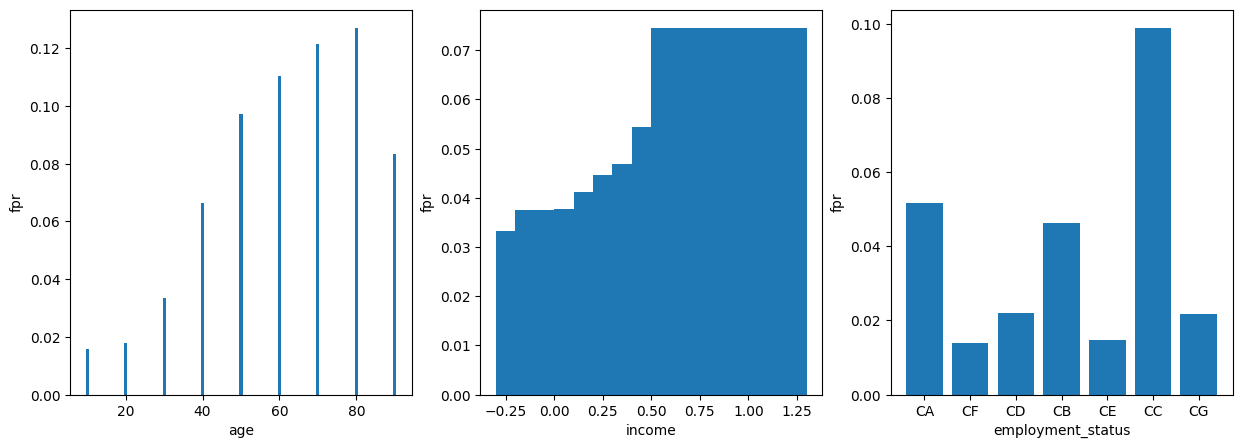

In [ ]:
plot_fpr_by_cat(ddct)

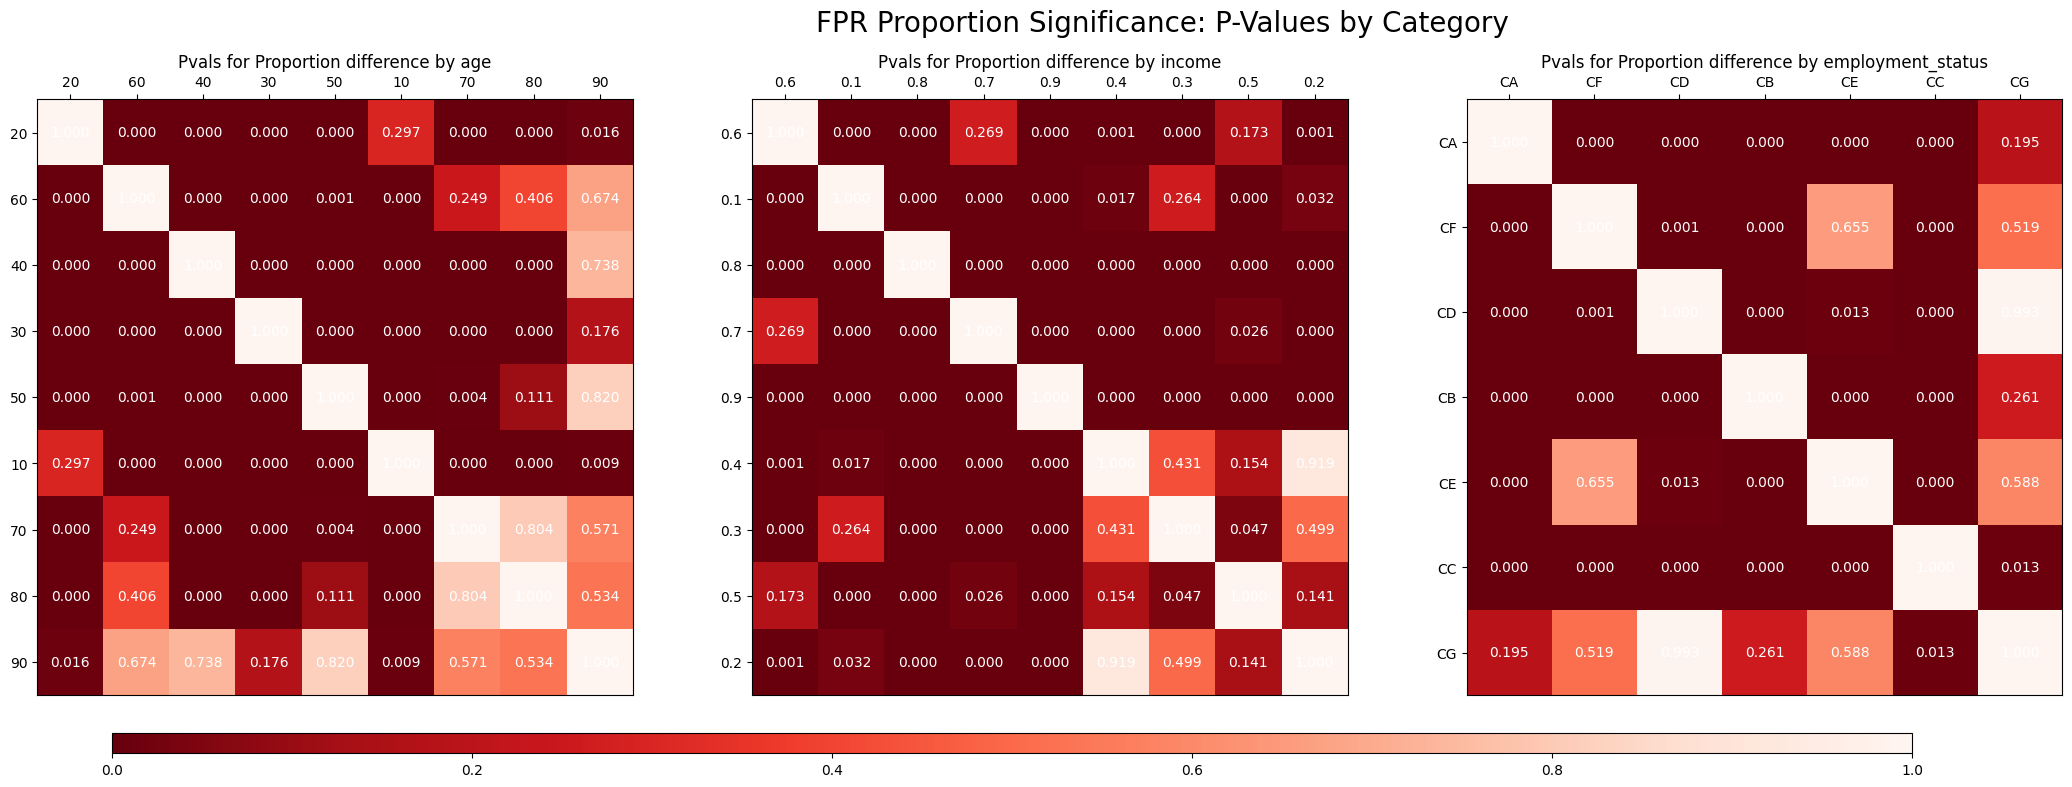

In [ ]:
plot_pval_heatmap(ddct)